# ✅ 1. Define the libraries and upload the dataset

In [1]:
# Step 1: Create a new environment
!python -m venv cleanenv

# Step 2: Activate it
# On Windows:
!cleanenv\Scripts\activate
# On Mac/Linux:
#source cleanenv/bin/activate

# Step 3: Install only what you need
!pip install numpy==1.26.4 scipy==1.13.0 scikit-learn==1.5.0 imbalanced-learn==0.13.0 tensorflow==2.18.0

Error: Command '['/kaggle/working/cleanenv/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: line 1: cleanenvScriptsactivate: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 23.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-l

In [2]:
# GOOD (pick one)
import torch                         # PyTorch only
# OR
import tensorflow as tf              # TensorFlow only
# OR
import jax                           # JAX only

2025-11-08 20:38:14.964387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762634295.159563      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762634295.213603      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Import TF first so cuDNN is registered once
import tensorflow as tf
import torch

In [4]:
import numpy, scipy, sklearn, imblearn, tensorflow as tf

print("numpy:", numpy.__version__)
print("scipy:", scipy.__version__)
print("scikit-learn:", sklearn.__version__)
print("imbalanced-learn:", imblearn.__version__)
print("tensorflow:", tf.__version__)

numpy: 1.26.4
scipy: 1.13.0
scikit-learn: 1.5.0
imbalanced-learn: 0.13.0
tensorflow: 2.18.0


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.utils import resample
from collections import Counter

This script creates **hourly-level dynamic features** for each patient during **Ramadan** using continuous glucose monitoring (CGM) data and lifestyle metrics (activity, sleep, physiology) from wearable devices.
It’s part of a preprocessing pipeline for modeling glucose behavior and hypoglycemia risk.

Here’s a complete explanation 👇

---

## 🧩 **Overall Goal**

To transform raw timestamped CGM and wearable data into **hourly summarized features** that represent glucose dynamics, lifestyle behavior, and physiological activity during Ramadan — ready for statistical or machine-learning analysis.

---

## 🧭 **1️⃣ Load and Parse Data**

* Loads the file:

  ```
  intraday_with_visits.csv
  ```

  which includes per-minute or per-sample CGM and Huawei sensor data.
* Converts all timestamps (`start`, `date`) to datetime format.
* Extracts:

  * `hour` → the nearest hour (e.g., 14:00, 15:00).
  * `hour_of_day` → the hour index (0–23).

👉 *Purpose:* Prepare a unified hourly timeline for every patient.

---

## 📆 **2️⃣ Filter for Ramadan Period**

* Keeps only data between **March 22 – April 19, 2023**.
* Ensures the dataset includes `cgm` readings (continuous glucose values).
* Adds a **binary flag `hypo`** = `True` when CGM ≤ 70 mg/dL (hypoglycemia reading).

👉 *Purpose:* Focus analysis strictly on the fasting month, removing other phases.

---

## ⏱ **3️⃣ Validate Hourly Windows**

* Keeps only hours with **≥4 CGM readings** to ensure data quality.
* This removes incomplete or sparse hours.

👉 *Purpose:* Guarantee each hourly feature represents stable glucose behavior.

---

## 📊 **4️⃣ Compute Hourly CGM Statistics**

For each patient and hour:

* `cgm_min` → minimum glucose value
* `cgm_max` → maximum glucose value
* `cgm_mean` → mean glucose level
* `cgm_std` → standard deviation (glucose variability)

Also adds:

* `hypo_label` → `1` if any CGM reading in that hour was ≤70 mg/dL.

👉 *Purpose:* Capture both variability and hypoglycemia presence within each hour.

---

## 🧮 **5️⃣ Composite Glucose Features**

Creates two derived indicators:

* `cgm_mean_plus_std`  → average + variability
* `cgm_mean_minus_std` → average – variability

👉 *Purpose:* Encode range boundaries for dynamic glucose variation.

---

## 🧠 **6️⃣ PCA on CGM Variables**

* Runs **Principal Component Analysis (PCA)** on `[cgm_min, cgm_max, cgm_mean, cgm_std]`.
* Extracts **3 principal components** (`pca_cgm1`, `pca_cgm2`, `pca_cgm3`).
* Reports explained variance (usually >95%).

👉 *Purpose:* Compress CGM dynamics into orthogonal, interpretable axes — summarizing glucose pattern, amplitude, and variability.

---

## 🏃‍♀️ **7️⃣ PCA on Lifestyle / Activity / Sleep Features**

* Selects available columns:

  ```
  steps, distance, calories, heart_rate, spo2, deep, light, rem, nap, awake
  ```
* Averages these per hour per patient.
* Runs PCA → extracts **3 lifestyle components**:

  * `pc1_activity_energy` → overall activity/energy output
  * `pc2_physiology` → physiological or heart-rate–related factors
  * `pc3_sleep_rest` → rest and sleep quality indices
* Reports explained variance ratio.

👉 *Purpose:* Reduce multiple wearable signals into interpretable latent factors.

---

## 📑 **8️⃣ Finalize and Sort**

* Orders the dataset by patient and hour.
* Keeps only relevant feature columns:

  ```
  cgm_min, cgm_max, cgm_mean, cgm_std,
  cgm_mean_plus_std, cgm_mean_minus_std,
  pca_cgm1–3, pc1_activity_energy, pc2_physiology, pc3_sleep_rest, hypo_label
  ```
* Prints a preview of the final dataset.

---

## 💾 **9️⃣ Save Hourly Feature File**

Exports the final hourly-level dataset to:

```
/kaggle/working/dynamic_hourly_features_ramadan.csv
```

Each row now represents **one patient-hour** with fully engineered glucose and lifestyle features.

---

## ✅ **Summary in One Line**

> This code aggregates intraday CGM and wearable sensor data into **hourly-level Ramadan features**, computing glucose statistics, detecting hypoglycemia, and summarizing glucose and lifestyle variability using **PCA-derived composite components** — producing a clean, feature-rich dataset for modeling hourly glucose dynamics during fasting.


In [6]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA

# =========================
# CONFIG
# =========================
CSV_PATH = "/kaggle/input/hmcdataset/intraday_with_visits.csv"  # ✅ update path if needed
OUT_HOURLY_CSV = "/kaggle/working/dynamic_hourly_features_ramadan.csv"

RAMADAN_START = pd.to_datetime("2023-03-22")
RAMADAN_END   = pd.to_datetime("2023-04-19")

# =========================
# STEP 0: Load & prepare data
# =========================
df = pd.read_csv(CSV_PATH)

# Parse timestamps
df["start"] = pd.to_datetime(df["start"], errors="coerce")
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["hour"] = df["start"].dt.floor("h")
df["hour_of_day"] = df["start"].dt.hour

# Numeric conversion
for col in df.columns:
    if col not in ["patientID", "huaweiID", "visit_assigned", "period_main", "start", "date", "hour", "hour_of_day"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# =========================
# STEP 0.1: Ramadan filter
# =========================
df = df[(df["date"] >= RAMADAN_START) & (df["date"] <= RAMADAN_END)].copy()

# Ensure CGM exists
if "cgm" not in df.columns:
    raise ValueError("❌ Dataset must include 'cgm' column.")
df_cgm = df.dropna(subset=["cgm"]).copy()

# Hypo reading flag (<= 70 mg/dL)
df_cgm["hypo"] = df_cgm["cgm"] <= 70

# =========================
# STEP 1: Filter valid hours (≥4 CGM readings)
# =========================
valid_hours = (
    df_cgm.groupby(["patientID", "hour"])
    .filter(lambda g: g["cgm"].notna().sum() >= 4)
)

# =========================
# STEP 2: Compute hourly CGM statistics
# =========================
hourly_features = (
    valid_hours
    .groupby(["patientID", "hour_of_day", "hour"], as_index=False)
    .agg(
        cgm_min=("cgm", "min"),
        cgm_max=("cgm", "max"),
        cgm_mean=("cgm", "mean"),
        cgm_std=("cgm", "std")
    )
)

# Hypoglycemia label per hour
hypo_per_hour = (
    valid_hours.groupby(["patientID", "hour"])["cgm"]
    .apply(lambda x: (x < 70).any())
    .reset_index(name="hypo_label")
)
hourly_features = hourly_features.merge(hypo_per_hour, on=["patientID", "hour"], how="left")

# =========================
# STEP 3: Composite CGM features
# =========================
hourly_features["cgm_mean_plus_std"] = hourly_features["cgm_mean"] + hourly_features["cgm_std"]
hourly_features["cgm_mean_minus_std"] = hourly_features["cgm_mean"] - hourly_features["cgm_std"]

# =========================
# STEP 4: PCA on CGM stats → 3 components
# =========================
pca_input_cgm = hourly_features[["cgm_min", "cgm_max", "cgm_mean", "cgm_std"]].fillna(0)
pca_cgm = PCA(n_components=3, random_state=42)
cgm_components = pca_cgm.fit_transform(pca_input_cgm)

hourly_features["pca_cgm1"] = cgm_components[:, 0]
hourly_features["pca_cgm2"] = cgm_components[:, 1]
hourly_features["pca_cgm3"] = cgm_components[:, 2]

print("CGM PCA explained variance:", pca_cgm.explained_variance_ratio_.round(3))

# =========================
# STEP 5: PCA on lifestyle/activity/sleep features
# =========================
lifestyle_cols = ["steps", "distance", "calories", "heart_rate", "spo2",
                  "deep", "light", "rem", "nap", "awake"]
lifestyle_cols = [c for c in lifestyle_cols if c in df_cgm.columns]

if lifestyle_cols:
    lifestyle_hourly = (
        df_cgm.groupby(["patientID", "hour"], as_index=False)[lifestyle_cols]
        .mean()
        .fillna(0)
    )

    # Merge lifestyle into hourly_features
    hourly_features = hourly_features.merge(
        lifestyle_hourly, on=["patientID", "hour"], how="left"
    ).fillna(0)

    # Run PCA
    pca_life = PCA(n_components=3, random_state=42)
    life_components = pca_life.fit_transform(hourly_features[lifestyle_cols])

    hourly_features["pc1_activity_energy"] = life_components[:, 0]
    hourly_features["pc2_physiology"] = life_components[:, 1]
    hourly_features["pc3_sleep_rest"] = life_components[:, 2]

    print("Lifestyle PCA explained variance:", pca_life.explained_variance_ratio_.round(3))

# =========================
# STEP 6: Finalize dataset
# =========================
hourly_features = hourly_features.sort_values(["patientID", "hour"]).reset_index(drop=True)

DYNAMIC_FEATURES = [
    "cgm_min", "cgm_max", "cgm_mean", "cgm_std",
    "cgm_mean_plus_std", "cgm_mean_minus_std",
    "pca_cgm1", "pca_cgm2", "pca_cgm3",
    "pc1_activity_energy", "pc2_physiology", "pc3_sleep_rest"
]

print(hourly_features[["patientID", "hour"] + DYNAMIC_FEATURES + ["hypo_label"]].head())


CGM PCA explained variance: [0.957 0.041 0.001]
Lifestyle PCA explained variance: [0.883 0.09  0.017]
   patientID                hour  cgm_min  cgm_max    cgm_mean    cgm_std  \
0         45 2023-03-22 00:00:00    216.0    238.0  229.916667   8.262273   
1         45 2023-03-22 01:00:00    184.0    216.0  203.916667  10.933338   
2         45 2023-03-22 02:00:00    169.0    189.0  178.500000   7.025926   
3         45 2023-03-22 03:00:00    127.0    175.0  153.916667  15.814023   
4         45 2023-03-22 04:00:00    116.0    146.0  132.750000  10.712143   

   cgm_mean_plus_std  cgm_mean_minus_std    pca_cgm1   pca_cgm2  pca_cgm3  \
0         238.178939          221.654394  122.152519  17.134021  1.320985   
1         214.850005          192.983329   76.456542   7.109642  2.654828   
2         185.525926          171.474074   37.052310  14.231018 -0.777581   
3         169.730690          138.102643   -8.187737  -9.873286  2.767731   
4         143.462143          122.037857  -44.2081

In [7]:
# ==============================================
# CLEAN REWRITE — Ramadan features + LSTM inputs
# ==============================================
import os
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --------------------
# GLOBAL CONFIG
# --------------------
CSV_INTRADAY_WITH_VISITS = "/kaggle/input/hmcdataset/intraday_with_visits.csv"
CSV_INTRADAY_BASIC       = "/kaggle/input/hmcdataset/intraday.csv"

OUT_HOURLY_CSV = "/kaggle/working/dynamic_hourly_features_ramadan.csv"

RAMADAN_START = pd.to_datetime("2023-03-22")
RAMADAN_END   = pd.to_datetime("2023-04-19")
HYPO_CUTOFF   = 70.0          # mg/dL
MIN_CGM_PER_H = 4
SEQ_LEN       = 24            # hours per sequence window

# Columns you *might* have (safe–checked)
LIFESTYLE_COLS_CANDIDATES = [
    "steps","distance","calories","heart_rate","spo2",
    "deep","light","rem","nap","awake"
]

# ---------------------------------------
# Utilities
# ---------------------------------------
def to_dt(x, utc_ok=True):
    return pd.to_datetime(x, errors="coerce", utc=utc_ok)

def standardize_and_pca(df, cols, n_components=3, random_state=42):
    """Return (components ndarray, explained_variance_ratio_) with standardization."""
    if not cols:
        return None, None
    X = df[cols].copy()
    X = X.fillna(0.0).astype(float)
    Xz = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_components, random_state=random_state)
    comps = pca.fit_transform(Xz)
    return comps, pca.explained_variance_ratio_

def ensure_numeric(df, exclude=("patientID","huaweiID","visit_assigned","period_main","start","date","hour","hour_of_day")):
    ex = set(exclude)
    for c in df.columns:
        if c not in ex:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def filter_ramadan(df):
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    return df[(df["date"] >= RAMADAN_START) & (df["date"] <= RAMADAN_END)].copy()

def label_hypo_per_hour(g):
    # label=1 if ANY CGM < HYPO_CUTOFF within the hour
    return int((g["cgm"] < HYPO_CUTOFF).any())

# ------------------------------------------------------
# Part A — Ramadan hourly features with PCA (save CSV)
# ------------------------------------------------------
def build_ramadan_hourly_features(
    in_csv=CSV_INTRADAY_WITH_VISITS,
    out_csv=OUT_HOURLY_CSV,
    min_cgm_per_hour=MIN_CGM_PER_H
):
    if not os.path.exists(in_csv):
        raise FileNotFoundError(f"Input not found: {in_csv}")

    df = pd.read_csv(in_csv)

    # Timestamp handling
    df["start"] = to_dt(df.get("start"))
    df["date"] = pd.to_datetime(df.get("date"), errors="coerce")
    df["hour"] = df["start"].dt.floor("h")
    df["hour_of_day"] = df["hour"].dt.hour

    # Make numerics consistent
    df = ensure_numeric(df)

    # Ramadan window
    df = filter_ramadan(df)

    # Require CGM
    if "cgm" not in df.columns:
        raise ValueError("❌ Dataset must include 'cgm' column.")
    df_cgm = df.dropna(subset=["cgm"]).copy()

    # Keep only hours with enough CGM samples
    valid_hours = (
        df_cgm
        .groupby(["patientID","hour"])
        .filter(lambda g: g["cgm"].notna().sum() >= min_cgm_per_hour)
    )

    # Base CGM stats per (patient, hour)
    hourly = (
        valid_hours
        .groupby(["patientID","hour"], as_index=False)
        .agg(
            cgm_min=("cgm","min"),
            cgm_max=("cgm","max"),
            cgm_mean=("cgm","mean"),
            cgm_std=("cgm","std")
        )
    )
    # Add hour_of_day
    hourly["hour_of_day"] = hourly["hour"].dt.hour

    # Hypo label (any CGM < cutoff during that hour)
    lab = (
        valid_hours
        .groupby(["patientID","hour"])["cgm"]
        .apply(lambda x: int((x < HYPO_CUTOFF).any()))
        .reset_index(name="hypo_label")
    )
    hourly = hourly.merge(lab, on=["patientID","hour"], how="left")

    # Composite CGM features
    hourly["cgm_mean_plus_std"]  = hourly["cgm_mean"] + hourly["cgm_std"]
    hourly["cgm_mean_minus_std"] = hourly["cgm_mean"] - hourly["cgm_std"]

    # PCA on CGM stats
    cgm_cols = ["cgm_min","cgm_max","cgm_mean","cgm_std"]
    cgm_comps, cgm_var = standardize_and_pca(hourly, cgm_cols, n_components=3)
    if cgm_comps is not None:
        hourly["pca_cgm1"] = cgm_comps[:,0]
        hourly["pca_cgm2"] = cgm_comps[:,1]
        hourly["pca_cgm3"] = cgm_comps[:,2]
        print("CGM PCA explained variance:", np.round(cgm_var, 3))

    # PCA on lifestyle/activity/sleep (if present)
    lifestyle_cols = [c for c in LIFESTYLE_COLS_CANDIDATES if c in df_cgm.columns]
    if lifestyle_cols:
        life_hourly = (
            df_cgm.groupby(["patientID","hour"], as_index=False)[lifestyle_cols]
                  .mean()
                  .fillna(0.0)
        )
        hourly = hourly.merge(life_hourly, on=["patientID","hour"], how="left").fillna(0.0)

        life_comps, life_var = standardize_and_pca(hourly, lifestyle_cols, n_components=3)
        if life_comps is not None:
            hourly["pc1_activity_energy"] = life_comps[:,0]
            hourly["pc2_physiology"]      = life_comps[:,1]
            hourly["pc3_sleep_rest"]      = life_comps[:,2]
            print("Lifestyle PCA explained variance:", np.round(life_var, 3))
    else:
        hourly["pc1_activity_energy"] = 0.0
        hourly["pc2_physiology"]      = 0.0
        hourly["pc3_sleep_rest"]      = 0.0

    # Sort + save
    hourly = hourly.sort_values(["patientID","hour"]).reset_index(drop=True)
    hourly.to_csv(out_csv, index=False)
    print(f"✅ Saved Ramadan hourly dynamic features to: {out_csv}")

    return hourly

# ------------------------------------------------------
# Part B1 — LSTM sequences from raw intraday (CGM-only)
# ------------------------------------------------------
def build_lstm_sequences_from_intraday(
    in_csv=CSV_INTRADAY_BASIC,
    seq_len=SEQ_LEN,
    label_cutoff=HYPO_CUTOFF,
    min_cgm_per_hour=MIN_CGM_PER_H,
    feature_cols=("cgm_mean",),  # CGM-only features expected
    test_size=0.2,
    random_state=42
):
    """CGM-only version (does not have PC features)."""
    if not os.path.exists(in_csv):
        raise FileNotFoundError(f"Input not found: {in_csv}")

    df = pd.read_csv(in_csv)
    df["start"] = to_dt(df.get("start"))
    df["hour"]  = df["start"].dt.floor("h")

    base = df[["patientID","hour","cgm"]].dropna(subset=["cgm"])

    valid = base.groupby(["patientID","hour"]).filter(lambda g: g["cgm"].notna().sum() >= min_cgm_per_hour)

    feats = (
        valid.groupby(["patientID","hour"])
             .agg(
                 cgm_std=("cgm","std"),
                 cgm_min=("cgm","min"),
                 cgm_mean=("cgm","mean"),
                 cgm_max=("cgm","max"),
                 hypo_label=("cgm", lambda x: int((x < label_cutoff).any()))
             )
             .reset_index()
             .sort_values(["patientID","hour"])
             .reset_index(drop=True)
    )

    # leakage-proof split
    unique_patients = feats["patientID"].unique()
    train_pat, test_pat = train_test_split(unique_patients, test_size=test_size, random_state=random_state)
    train_df = feats[feats["patientID"].isin(train_pat)].copy()
    test_df  = feats[feats["patientID"].isin(test_pat)].copy()

    # build windows
    feature_cols = list(feature_cols)
    for col in feature_cols + ["hypo_label"]:
        if col not in feats.columns:
            raise KeyError(f"Column '{col}' not found in CGM-only features. "
                           f"Use build_lstm_sequences_from_hourly() if you need '{col}'.")

    def build_sequences(df_in, feature_cols, label_col="hypo_label", seq_len=seq_len):
        X, y = [], []
        for pid, grp in df_in.groupby("patientID"):
            grp = grp.sort_values("hour").reset_index(drop=True)
            for i in range(len(grp) - seq_len):
                X.append(grp.loc[i:i+seq_len-1, feature_cols].values)
                y.append(int(grp.loc[i+seq_len, label_col]))
        return np.array(X), np.array(y)

    X_train, y_train = build_sequences(train_df, feature_cols)
    X_test,  y_test  = build_sequences(test_df,  feature_cols)

    print(f"✅ Sequences (CGM-only) — train: {X_train.shape}, test: {X_test.shape} | features={feature_cols}")
    return (X_train, y_train, X_test, y_test), (train_df, test_df)

# ------------------------------------------------------
# Part B2 — LSTM sequences from HOURLY CSV (supports PCs)
# ------------------------------------------------------
def build_lstm_sequences_from_hourly(
    hourly_df_or_path=OUT_HOURLY_CSV,
    seq_len=SEQ_LEN,
    feature_cols=("cgm_mean","cgm_std","pc1_activity_energy"),  # includes PC feature(s)
    test_size=0.2,
    random_state=42
):
    """
    Build sequences directly from the Ramadan hourly features CSV/DataFrame.
    Use this when you want columns like 'pc1_activity_energy', 'pca_cgm1', etc.
    """
    if isinstance(hourly_df_or_path, (str, Path)):
        if not os.path.exists(hourly_df_or_path):
            raise FileNotFoundError(f"Hourly features not found: {hourly_df_or_path}")
        hourly = pd.read_csv(hourly_df_or_path)
    else:
        hourly = hourly_df_or_path.copy()

    required = {"patientID","hour","hypo_label"}
    missing = required - set(hourly.columns)
    if missing:
        raise KeyError(f"Hourly features missing required columns: {missing}")

    # Ensure hour is datetime
    hourly["hour"] = pd.to_datetime(hourly["hour"], errors="coerce")

    # Keep only required + wanted features
    feature_cols = list(feature_cols)
    missing_feats = [c for c in feature_cols if c not in hourly.columns]
    if missing_feats:
        raise KeyError(f"Requested feature(s) not found in hourly CSV: {missing_feats}")

    hourly = hourly.sort_values(["patientID","hour"]).reset_index(drop=True)

    # leakage-proof split
    unique_patients = hourly["patientID"].unique()
    train_pat, test_pat = train_test_split(unique_patients, test_size=test_size, random_state=random_state)
    train_df = hourly[hourly["patientID"].isin(train_pat)].copy()
    test_df  = hourly[hourly["patientID"].isin(test_pat)].copy()

    def build_sequences(df_in, feature_cols, label_col="hypo_label", seq_len=seq_len):
        X, y = [], []
        for pid, grp in df_in.groupby("patientID"):
            grp = grp.sort_values("hour").reset_index(drop=True)
            for i in range(len(grp) - seq_len):
                X.append(grp.loc[i:i+seq_len-1, feature_cols].values)
                y.append(int(grp.loc[i+seq_len, label_col]))
        return np.array(X), np.array(y)

    X_train, y_train = build_sequences(train_df, feature_cols)
    X_test,  y_test  = build_sequences(test_df,  feature_cols)

    print(f"✅ Sequences (Hourly/PCs) — train: {X_train.shape}, test: {X_test.shape} | features={feature_cols}")
    return (X_train, y_train, X_test, y_test), (train_df, test_df)

# --------------------
# Run both parts
# --------------------
if __name__ == "__main__":
    # Part A: Ramadan hourly features with PCA
    try:
        hourly_features = build_ramadan_hourly_features(
            in_csv=CSV_INTRADAY_WITH_VISITS,
            out_csv=OUT_HOURLY_CSV,
            min_cgm_per_hour=MIN_CGM_PER_H
        )
    except Exception as e:
        print(f"[WARN] Skipping Ramadan feature build: {e}")
        hourly_features = None

    # OPTION 1 — CGM-only sequences from raw intraday.csv
    # (Use this when you're NOT using pc1_activity_energy / PCA lifestyle features)
    # (X_train, y_train, X_test, y_test), _ = build_lstm_sequences_from_intraday(
    #     in_csv=CSV_INTRADAY_BASIC,
    #     seq_len=SEQ_LEN,
    #     label_cutoff=HYPO_CUTOFF,
    #     min_cgm_per_hour=MIN_CGM_PER_H,
    #     feature_cols=("cgm_mean","cgm_std","cgm_min","cgm_max")
    # )

    # OPTION 2 — Sequences from HOURLY CSV (so you can use PC features)
    try:
        (X_train, y_train, X_test, y_test), _ = build_lstm_sequences_from_hourly(
            hourly_df_or_path=OUT_HOURLY_CSV,
            seq_len=SEQ_LEN,
            feature_cols=("cgm_mean","cgm_std","pc1_activity_energy")  # ✅ now valid
        )
    except Exception as e:
        print(f"[WARN] Skipping hourly-based sequence build: {e}")


CGM PCA explained variance: [0.743 0.255 0.001]
Lifestyle PCA explained variance: [0.287 0.24  0.109]
✅ Saved Ramadan hourly dynamic features to: /kaggle/working/dynamic_hourly_features_ramadan.csv
✅ Sequences (Hourly/PCs) — train: (15173, 24, 3), test: (3722, 24, 3) | features=['cgm_mean', 'cgm_std', 'pc1_activity_energy']


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

def build_ramadan_hourly_features_leakfree(
    in_csv=CSV_INTRADAY_WITH_VISITS,
    out_csv=OUT_HOURLY_CSV,
    min_cgm_per_hour=MIN_CGM_PER_H,
    test_size=0.2,
    random_state=42,
    save_artifacts=True
):
    if not os.path.exists(in_csv):
        raise FileNotFoundError(f"Input not found: {in_csv}")

    df = pd.read_csv(in_csv)

    # --- timestamps / numerics
    df["start"] = to_dt(df.get("start"))
    # If "date" column is unreliable, derive it from start:
    if "date" not in df.columns or df["date"].isna().all():
        df["date"] = df["start"].dt.tz_localize(None).dt.date
        df["date"] = pd.to_datetime(df["date"])

    df["hour"] = df["start"].dt.floor("h")
    df["hour_of_day"] = df["hour"].dt.hour
    df = ensure_numeric(df)

    # --- Ramadan filter
    df = filter_ramadan(df)

    # --- require CGM
    if "cgm" not in df.columns:
        raise ValueError("❌ Dataset must include 'cgm' column.")
    df_cgm = df.dropna(subset=["cgm"]).copy()

    # --- only hours with enough CGM samples
    valid_hours = (
        df_cgm.groupby(["patientID","hour"])
              .filter(lambda g: g["cgm"].notna().sum() >= min_cgm_per_hour)
    )

    # --- base hourly CGM stats
    hourly = (
        valid_hours
        .groupby(["patientID","hour"], as_index=False)
        .agg(
            cgm_min=("cgm","min"),
            cgm_max=("cgm","max"),
            cgm_mean=("cgm","mean"),
            cgm_std=("cgm","std")
        )
        .sort_values(["patientID","hour"])
        .reset_index(drop=True)
    )
    hourly["hour_of_day"] = hourly["hour"].dt.hour

    # --- hypo label
    lab = (
        valid_hours.groupby(["patientID","hour"])["cgm"]
        .apply(lambda x: int((x < HYPO_CUTOFF).any()))
        .reset_index(name="hypo_label")
    )
    hourly = hourly.merge(lab, on=["patientID","hour"], how="left")

    # --- composite CGM features
    hourly["cgm_mean_plus_std"]  = hourly["cgm_mean"] + hourly["cgm_std"]
    hourly["cgm_mean_minus_std"] = hourly["cgm_mean"] - hourly["cgm_std"]

    # --- optional lifestyle block
    lifestyle_cols = [c for c in LIFESTYLE_COLS_CANDIDATES if c in df_cgm.columns]
    if lifestyle_cols:
        life_hourly = (
            df_cgm.groupby(["patientID","hour"], as_index=False)[lifestyle_cols]
                  .mean()
                  .fillna(0.0)
        )
        hourly = hourly.merge(life_hourly, on=["patientID","hour"], how="left").fillna(0.0)
    else:
        hourly["pc1_activity_energy"] = 0.0
        hourly["pc2_physiology"]      = 0.0
        hourly["pc3_sleep_rest"]      = 0.0

    # --- split patients BEFORE PCA to avoid leakage
    unique_patients = hourly["patientID"].dropna().unique()
    train_pat, test_pat = train_test_split(unique_patients, test_size=test_size, random_state=random_state)
    train_df = hourly[hourly["patientID"].isin(train_pat)].copy()
    test_df  = hourly[hourly["patientID"].isin(test_pat)].copy()

    # --- fit CGM PCA on train only, transform both
    cgm_cols = ["cgm_min","cgm_max","cgm_mean","cgm_std"]
    scal_cgm = StandardScaler().fit(train_df[cgm_cols].fillna(0.0))
    pca_cgm  = PCA(n_components=3, random_state=random_state).fit(scal_cgm.transform(train_df[cgm_cols].fillna(0.0)))

    def _apply_cgm(df):
        X = scal_cgm.transform(df[cgm_cols].fillna(0.0))
        Z = pca_cgm.transform(X)
        out = df.copy()
        out["pca_cgm1"], out["pca_cgm2"], out["pca_cgm3"] = Z[:,0], Z[:,1], Z[:,2]
        return out

    train_df = _apply_cgm(train_df)
    test_df  = _apply_cgm(test_df)

    # --- lifestyle PCA (if present), also fit on train only
    if lifestyle_cols:
        scal_life = StandardScaler().fit(train_df[lifestyle_cols])
        pca_life  = PCA(n_components=3, random_state=random_state).fit(scal_life.transform(train_df[lifestyle_cols]))

        def _apply_life(df):
            X = scal_life.transform(df[lifestyle_cols])
            Z = pca_life.transform(X)
            out = df.copy()
            out["pc1_activity_energy"] = Z[:,0]
            out["pc2_physiology"]      = Z[:,1]
            out["pc3_sleep_rest"]      = Z[:,2]
            return out

        train_df = _apply_life(train_df)
        test_df  = _apply_life(test_df)

    # --- save & return (combined for convenience)
    hourly_out = pd.concat([train_df, test_df], axis=0).sort_values(["patientID","hour"]).reset_index(drop=True)
    hourly_out.to_csv(out_csv, index=False)
    print(f"✅ Saved leak‑free Ramadan hourly features to: {out_csv}")

    # Optionally save artifacts for reproducibility
    if save_artifacts:
        os.makedirs("/kaggle/working/artifacts", exist_ok=True)
        joblib.dump({"scal_cgm":scal_cgm, "pca_cgm":pca_cgm}, "/kaggle/working/artifacts/cgm_pca.joblib")
        if lifestyle_cols:
            joblib.dump({"scal_life":scal_life, "pca_life":pca_life, "cols":lifestyle_cols},
                        "/kaggle/working/artifacts/life_pca.joblib")

    return hourly_out, (train_pat, test_pat)


In [9]:
def build_lstm_sequences_from_hourly(
    hourly_df_or_path=OUT_HOURLY_CSV,
    seq_len=SEQ_LEN,
    feature_cols=("cgm_mean","cgm_std","pc1_activity_energy"),
    split_patients=None  # <-- (train_pat, test_pat)
):
    if isinstance(hourly_df_or_path, (str, Path)):
        if not os.path.exists(hourly_df_or_path):
            raise FileNotFoundError(f"Hourly features not found: {hourly_df_or_path}")
        hourly = pd.read_csv(hourly_df_or_path)
    else:
        hourly = hourly_df_or_path.copy()

    req = {"patientID","hour","hypo_label"}
    missing = req - set(hourly.columns)
    if missing:
        raise KeyError(f"Hourly features missing required columns: {missing}")

    hourly["hour"] = pd.to_datetime(hourly["hour"], errors="coerce")
    feature_cols = list(feature_cols)
    miss = [c for c in feature_cols if c not in hourly.columns]
    if miss:
        raise KeyError(f"Requested feature(s) not found in hourly CSV: {miss}")

    hourly = hourly.sort_values(["patientID","hour"]).reset_index(drop=True)

    if split_patients is None:
        raise ValueError("Pass split_patients=(train_pat, test_pat) from the leak‑free PCA step.")
    train_pat, test_pat = split_patients
    train_df = hourly[hourly["patientID"].isin(train_pat)].copy()
    test_df  = hourly[hourly["patientID"].isin(test_pat)].copy()

    def build_sequences(df_in, feature_cols, label_col="hypo_label", seq_len=SEQ_LEN):
        X, y = [], []
        for pid, grp in df_in.groupby("patientID"):
            grp = grp.sort_values("hour").reset_index(drop=True)
            for i in range(len(grp) - seq_len):
                X.append(grp.loc[i:i+seq_len-1, feature_cols].values)
                y.append(int(grp.loc[i+seq_len, label_col]))
        return np.array(X), np.array(y)

    X_train, y_train = build_sequences(train_df, feature_cols)
    X_test,  y_test  = build_sequences(test_df,  feature_cols)

    print(f"✅ Sequences (Hourly/PCs, leak‑free) — train: {X_train.shape}, test: {X_test.shape} | features={feature_cols}")
    return (X_train, y_train, X_test, y_test), (train_df, test_df)


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 7.5 MB/s  0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.2
    Uninstalling joblib-1.5.2:
      Successfully uninstalled joblib-1.5.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.0
    Uninstalling scikit-learn-1.5.0:
      Successfully uninstalled scikit-learn-1.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scikit-learn]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you h

I0000 00:00:1762634359.339008      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



🚀 Training [none__LSTM_100] with class-weighted focal loss
Epoch 1/5


I0000 00:00:1762634363.722553      85 cuda_dnn.cc:529] Loaded cuDNN version 90300


835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9382 - loss: 0.0257

835/835 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9382 - loss: 0.0257 - val_accuracy: 0.9660 - val_loss: 0.0021
Epoch 2/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9532 - loss: 0.0162 - val_accuracy: 0.9685 - val_loss: 0.0022
Epoch 3/5
830/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9527 - loss: 0.0155

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9527 - loss: 0.0155 - val_accuracy: 0.9695 - val_loss: 0.0021
Epoch 4/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9546 - loss: 0.0151 - val_accuracy: 0.9678 - val_loss: 0.0025
Epoch 5/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9546 - loss: 0.0152 - val_accuracy: 0.9691 - val_loss: 0.0023
Restoring model weights from the end of the best epoch: 3.
⏱️ Training Time: 41.85s
📌 [none__LSTM_100] thresholds → Youden=0.4072, PR-F1=0.4072 (window [0.4,0.6])

🚀 Training [none__LSTM_50] with class-weighted focal loss
Epoch 1/5
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9508 - loss: 0.0251

835/835 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9508 - loss: 0.0251 - val_accuracy: 0.9656 - val_loss: 0.0023
Epoch 2/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9509 - loss: 0.0169 - val_accuracy: 0.9656 - val_loss: 0.0023
Epoch 3/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9519 - loss: 0.0164 - val_accuracy: 0.9681 - val_loss: 0.0023
Epoch 4/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9532 - loss: 0.0159 - val_accuracy: 0.9691 - val_loss: 0.0024
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
⏱️ Training Time: 30.10s
📌 [none__LSTM_50] thresholds → Youden=0.4078, PR-F1=0.4012 (window [0.4,0.6])

🚀 Training [none__LSTM_25_L1] with class-weighted focal loss
Epoch 1/5
829/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9170 - loss: 0.0365

835/835 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9173 - loss: 0.0364 - val_accuracy: 0.9656 - val_loss: 0.0051
Epoch 2/5
829/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9508 - loss: 0.0202

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9508 - loss: 0.0202 - val_accuracy: 0.9656 - val_loss: 0.0044
Epoch 3/5
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9516 - loss: 0.0192

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9516 - loss: 0.0192 - val_accuracy: 0.9658 - val_loss: 0.0042
Epoch 4/5
830/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9521 - loss: 0.0190

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9521 - loss: 0.0190 - val_accuracy: 0.9658 - val_loss: 0.0039
Epoch 5/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9537 - loss: 0.0180 - val_accuracy: 0.9662 - val_loss: 0.0040
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 38.18s
📌 [none__LSTM_25_L1] thresholds → Youden=0.4052, PR-F1=0.4052 (window [0.4,0.6])

🚀 Training [none__LSTM_25_L2] with class-weighted focal loss
Epoch 1/5
831/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9506 - loss: 0.0269

835/835 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9506 - loss: 0.0269 - val_accuracy: 0.9656 - val_loss: 0.0028
Epoch 2/5
833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9522 - loss: 0.0174

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9522 - loss: 0.0174 - val_accuracy: 0.9685 - val_loss: 0.0027
Epoch 3/5
830/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9533 - loss: 0.0168

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9533 - loss: 0.0168 - val_accuracy: 0.9695 - val_loss: 0.0026
Epoch 4/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9543 - loss: 0.0161 - val_accuracy: 0.9689 - val_loss: 0.0028
Epoch 5/5
829/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9550 - loss: 0.0159

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9550 - loss: 0.0159 - val_accuracy: 0.9697 - val_loss: 0.0026
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 37.98s
📌 [none__LSTM_25_L2] thresholds → Youden=0.4038, PR-F1=0.4038 (window [0.4,0.6])

🚀 Training [none__BiLSTM] with class-weighted focal loss
Epoch 1/5
833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9457 - loss: 0.0252

835/835 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9457 - loss: 0.0251 - val_accuracy: 0.9660 - val_loss: 0.0024
Epoch 2/5
832/835 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9527 - loss: 0.0163

835/835 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9527 - loss: 0.0163 - val_accuracy: 0.9676 - val_loss: 0.0022
Epoch 3/5
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9550 - loss: 0.0151

835/835 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9550 - loss: 0.0151 - val_accuracy: 0.9691 - val_loss: 0.0022
Epoch 4/5
833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9544 - loss: 0.0150

835/835 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9544 - loss: 0.0150 - val_accuracy: 0.9693 - val_loss: 0.0022
Epoch 5/5
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9559 - loss: 0.0146

835/835 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9559 - loss: 0.0146 - val_accuracy: 0.9699 - val_loss: 0.0020
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 59.04s
📌 [none__BiLSTM] thresholds → Youden=0.4130, PR-F1=0.4130 (window [0.4,0.6])

🔁 Resampling: oversample_seq → X=(50844, 36, 3), y=Counter({1: 25422, 0: 25422})

🚀 Training [oversample_seq__LSTM_100] with class-weighted focal loss
Epoch 1/5
1585/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7529 - loss: 0.0343

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7530 - loss: 0.0342 - val_accuracy: 0.8850 - val_loss: 0.0292
Epoch 2/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8069 - loss: 0.0242 - val_accuracy: 0.8780 - val_loss: 0.0312
Epoch 3/5
1583/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8210 - loss: 0.0217

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8210 - loss: 0.0216 - val_accuracy: 0.9019 - val_loss: 0.0202
Epoch 4/5
1585/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8387 - loss: 0.0187

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8387 - loss: 0.0187 - val_accuracy: 0.9134 - val_loss: 0.0156
Epoch 5/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8627 - loss: 0.0148 - val_accuracy: 0.9075 - val_loss: 0.0165
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 68.26s
📌 [oversample_seq__LSTM_100] thresholds → Youden=0.4038, PR-F1=0.5983 (window [0.4,0.6])

🚀 Training [oversample_seq__LSTM_50] with class-weighted focal loss
Epoch 1/5
1584/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7088 - loss: 0.0398

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7090 - loss: 0.0398 - val_accuracy: 0.8889 - val_loss: 0.0259
Epoch 2/5
1585/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8047 - loss: 0.0253

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8047 - loss: 0.0253 - val_accuracy: 0.8916 - val_loss: 0.0249
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8128 - loss: 0.0237 - val_accuracy: 0.8953 - val_loss: 0.0264
Epoch 4/5
1583/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8162 - loss: 0.0226

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8162 - loss: 0.0226 - val_accuracy: 0.9033 - val_loss: 0.0229
Epoch 5/5
1583/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8228 - loss: 0.0211

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8228 - loss: 0.0211 - val_accuracy: 0.9073 - val_loss: 0.0185
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 65.98s
📌 [oversample_seq__LSTM_50] thresholds → Youden=0.4724, PR-F1=0.5978 (window [0.4,0.6])

🚀 Training [oversample_seq__LSTM_25_L1] with class-weighted focal loss
Epoch 1/5
1583/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7234 - loss: 0.0429

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7237 - loss: 0.0428 - val_accuracy: 0.8831 - val_loss: 0.0303
Epoch 2/5
1583/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8059 - loss: 0.0281

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8059 - loss: 0.0281 - val_accuracy: 0.8848 - val_loss: 0.0283
Epoch 3/5
1584/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8095 - loss: 0.0264

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8095 - loss: 0.0264 - val_accuracy: 0.8984 - val_loss: 0.0245
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8137 - loss: 0.0253 - val_accuracy: 0.9019 - val_loss: 0.0261
Epoch 5/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8171 - loss: 0.0243 - val_accuracy: 0.8871 - val_loss: 0.0269
Restoring model weights from the end of the best epoch: 3.
⏱️ Training Time: 66.51s
📌 [oversample_seq__LSTM_25_L1] thresholds → Youden=0.4186, PR-F1=0.5813 (window [0.4,0.6])

🚀 Training [oversample_seq__LSTM_25_L2] with class-weighted focal loss
Epoch 1/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7147 - loss: 0.0411

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7148 - loss: 0.0410 - val_accuracy: 0.8739 - val_loss: 0.0279
Epoch 2/5
1587/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8029 - loss: 0.0265

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8029 - loss: 0.0265 - val_accuracy: 0.8943 - val_loss: 0.0237
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8144 - loss: 0.0245 - val_accuracy: 0.8877 - val_loss: 0.0260
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8185 - loss: 0.0236

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8185 - loss: 0.0236 - val_accuracy: 0.9013 - val_loss: 0.0209
Epoch 5/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8237 - loss: 0.0223 - val_accuracy: 0.8982 - val_loss: 0.0212
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 66.11s
📌 [oversample_seq__LSTM_25_L2] thresholds → Youden=0.4443, PR-F1=0.5983 (window [0.4,0.6])

🚀 Training [oversample_seq__BiLSTM] with class-weighted focal loss
Epoch 1/5
1586/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7422 - loss: 0.0358

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.7423 - loss: 0.0358 - val_accuracy: 0.9019 - val_loss: 0.0224
Epoch 2/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8111 - loss: 0.0237

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8111 - loss: 0.0237 - val_accuracy: 0.9060 - val_loss: 0.0205
Epoch 3/5
1587/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8214 - loss: 0.0217

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8214 - loss: 0.0217 - val_accuracy: 0.9151 - val_loss: 0.0152
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8387 - loss: 0.0183

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8387 - loss: 0.0183 - val_accuracy: 0.9211 - val_loss: 0.0120
Epoch 5/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8652 - loss: 0.0141 - val_accuracy: 0.9165 - val_loss: 0.0131
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 103.80s
📌 [oversample_seq__BiLSTM] thresholds → Youden=0.4272, PR-F1=0.5984 (window [0.4,0.6])

🔁 Resampling: undersample_seq → X=(2560, 36, 3), y=Counter({1: 1280, 0: 1280})

🚀 Training [undersample_seq__LSTM_100] with class-weighted focal loss
Epoch 1/5
75/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5539 - loss: 0.0644

80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5598 - loss: 0.0635 - val_accuracy: 0.9064 - val_loss: 0.0168
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7639 - loss: 0.0352 - val_accuracy: 0.8679 - val_loss: 0.0271
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7708 - loss: 0.0319 - val_accuracy: 0.8800 - val_loss: 0.0233
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7908 - loss: 0.0290 - val_accuracy: 0.8873 - val_loss: 0.0228
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
⏱️ Training Time: 7.63s
📌 [undersample_seq__LSTM_100] thresholds → Youden=0.4426, PR-F1=0.5995 (window [0.4,0.6])

🚀 Training [undersample_seq__LSTM_50] with class-weighted focal loss
Epoch 1/5
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5274 - loss: 0.0664

80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5288 - loss: 0.0662 - val_accuracy: 0.8566 - val_loss: 0.0423
Epoch 2/5
73/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6988 - loss: 0.0439

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7011 - loss: 0.0435 - val_accuracy: 0.8349 - val_loss: 0.0353
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7505 - loss: 0.0372

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7507 - loss: 0.0372 - val_accuracy: 0.8421 - val_loss: 0.0331
Epoch 4/5
73/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7717 - loss: 0.0342

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7721 - loss: 0.0340 - val_accuracy: 0.8477 - val_loss: 0.0309
Epoch 5/5
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7773 - loss: 0.0319

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7774 - loss: 0.0319 - val_accuracy: 0.8572 - val_loss: 0.0288
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 8.75s
📌 [undersample_seq__LSTM_50] thresholds → Youden=0.4011, PR-F1=0.5999 (window [0.4,0.6])

🚀 Training [undersample_seq__LSTM_25_L1] with class-weighted focal loss
Epoch 1/5
76/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4965 - loss: 0.0778

80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4977 - loss: 0.0773 - val_accuracy: 0.9211 - val_loss: 0.0398
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6433 - loss: 0.0538

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6439 - loss: 0.0537 - val_accuracy: 0.8753 - val_loss: 0.0281
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7468 - loss: 0.0399 - val_accuracy: 0.8502 - val_loss: 0.0337
Epoch 4/5
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7760 - loss: 0.0362

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7763 - loss: 0.0362 - val_accuracy: 0.8823 - val_loss: 0.0236
Epoch 5/5
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7656 - loss: 0.0359

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7660 - loss: 0.0359 - val_accuracy: 0.9044 - val_loss: 0.0197
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 8.89s
📌 [undersample_seq__LSTM_25_L1] thresholds → Youden=0.4358, PR-F1=0.5854 (window [0.4,0.6])

🚀 Training [undersample_seq__LSTM_25_L2] with class-weighted focal loss
Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5431 - loss: 0.0735

80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5435 - loss: 0.0734 - val_accuracy: 0.9035 - val_loss: 0.0263
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7086 - loss: 0.0441 - val_accuracy: 0.8615 - val_loss: 0.0292
Epoch 3/5
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7616 - loss: 0.0373

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7618 - loss: 0.0372 - val_accuracy: 0.8761 - val_loss: 0.0241
Epoch 4/5
73/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7742 - loss: 0.0332

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7751 - loss: 0.0330 - val_accuracy: 0.8904 - val_loss: 0.0205
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7797 - loss: 0.0319 - val_accuracy: 0.8819 - val_loss: 0.0238
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 8.73s
📌 [undersample_seq__LSTM_25_L2] thresholds → Youden=0.4059, PR-F1=0.5961 (window [0.4,0.6])

🚀 Training [undersample_seq__BiLSTM] with class-weighted focal loss
Epoch 1/5
76/80 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5055 - loss: 0.0675

80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5097 - loss: 0.0668 - val_accuracy: 0.8603 - val_loss: 0.0257
Epoch 2/5
76/80 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7522 - loss: 0.0380

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7531 - loss: 0.0378 - val_accuracy: 0.8652 - val_loss: 0.0250
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7798 - loss: 0.0327 - val_accuracy: 0.8640 - val_loss: 0.0279
Epoch 4/5
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7825 - loss: 0.0313

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7827 - loss: 0.0313 - val_accuracy: 0.8732 - val_loss: 0.0247
Epoch 5/5
76/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7801 - loss: 0.0317

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7806 - loss: 0.0317 - val_accuracy: 0.8815 - val_loss: 0.0206
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 13.15s
📌 [undersample_seq__BiLSTM] thresholds → Youden=0.4112, PR-F1=0.5999 (window [0.4,0.6])

🔁 Resampling: smote → X=(50844, 36, 3), y=Counter({0: 25422, 1: 25422})

🚀 Training [smote__LSTM_100] with class-weighted focal loss
Epoch 1/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7546 - loss: 0.0336

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7547 - loss: 0.0336 - val_accuracy: 0.8904 - val_loss: 0.0222
Epoch 2/5
1586/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8236 - loss: 0.0216

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8237 - loss: 0.0216 - val_accuracy: 0.9171 - val_loss: 0.0149
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8506 - loss: 0.0163 - val_accuracy: 0.8951 - val_loss: 0.0251
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8635 - loss: 0.0137 - val_accuracy: 0.8833 - val_loss: 0.0341
Epoch 5/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8740 - loss: 0.0120 - val_accuracy: 0.8809 - val_loss: 0.0413
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
⏱️ Training Time: 68.64s
📌 [smote__LSTM_100] thresholds → Youden=0.4036, PR-F1=0.5957 (window [0.4,0.6])

🚀 Training [smote__LSTM_50] with class-weighted focal loss
Epoch 1/5
1588/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7119 - loss: 0.0407

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7119 - loss: 0.0407 - val_accuracy: 0.8910 - val_loss: 0.0219
Epoch 2/5
1586/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8095 - loss: 0.0246

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8095 - loss: 0.0246 - val_accuracy: 0.9044 - val_loss: 0.0161
Epoch 3/5
1584/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8327 - loss: 0.0198

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8327 - loss: 0.0198 - val_accuracy: 0.9116 - val_loss: 0.0160
Epoch 4/5
1586/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8501 - loss: 0.0165

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8501 - loss: 0.0165 - val_accuracy: 0.9083 - val_loss: 0.0159
Epoch 5/5
1584/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8586 - loss: 0.0148

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8586 - loss: 0.0148 - val_accuracy: 0.9126 - val_loss: 0.0159
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 67.69s
📌 [smote__LSTM_50] thresholds → Youden=0.4078, PR-F1=0.5969 (window [0.4,0.6])

🚀 Training [smote__LSTM_25_L1] with class-weighted focal loss
Epoch 1/5
1585/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7061 - loss: 0.0449

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7063 - loss: 0.0449 - val_accuracy: 0.8852 - val_loss: 0.0227
Epoch 2/5
1585/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8159 - loss: 0.0265

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8159 - loss: 0.0265 - val_accuracy: 0.9042 - val_loss: 0.0174
Epoch 3/5
1584/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8336 - loss: 0.0222

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8337 - loss: 0.0222 - val_accuracy: 0.9149 - val_loss: 0.0148
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8410 - loss: 0.0197 - val_accuracy: 0.8939 - val_loss: 0.0231
Epoch 5/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8446 - loss: 0.0188 - val_accuracy: 0.8959 - val_loss: 0.0237
Restoring model weights from the end of the best epoch: 3.
⏱️ Training Time: 68.79s
📌 [smote__LSTM_25_L1] thresholds → Youden=0.4155, PR-F1=0.5983 (window [0.4,0.6])

🚀 Training [smote__LSTM_25_L2] with class-weighted focal loss
Epoch 1/5
1583/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7280 - loss: 0.0392

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7282 - loss: 0.0392 - val_accuracy: 0.8972 - val_loss: 0.0178
Epoch 2/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8182 - loss: 0.0238 - val_accuracy: 0.8906 - val_loss: 0.0242
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8392 - loss: 0.0191 - val_accuracy: 0.8897 - val_loss: 0.0266
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8489 - loss: 0.0173 - val_accuracy: 0.8980 - val_loss: 0.0247
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
⏱️ Training Time: 55.10s
📌 [smote__LSTM_25_L2] thresholds → Youden=0.4671, PR-F1=0.5971 (window [0.4,0.6])

🚀 Training [smote__BiLSTM] with class-weighted focal loss
Epoch 1/5
1587/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7500 - loss: 0.0346

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.7501 - loss: 0.0346 - val_accuracy: 0.9279 - val_loss: 0.0103
Epoch 2/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8371 - loss: 0.0189 - val_accuracy: 0.9052 - val_loss: 0.0170
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8570 - loss: 0.0156 - val_accuracy: 0.9174 - val_loss: 0.0137
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8671 - loss: 0.0134 - val_accuracy: 0.9025 - val_loss: 0.0201
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
⏱️ Training Time: 83.24s
📌 [smote__BiLSTM] thresholds → Youden=0.4095, PR-F1=0.5999 (window [0.4,0.6])

🔁 Resampling: smoteenn → X=(47885, 36, 3), y=Counter({1: 25422, 0: 22463})

🚀 Training [smoteenn__LSTM_100] with class-weighted focal loss
Epoch 1/5
1491/1497 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7649 - loss: 0.0309

1497/1497 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7652 - loss: 0.0309 - val_accuracy: 0.9239 - val_loss: 0.0126
Epoch 2/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8436 - loss: 0.0173 - val_accuracy: 0.8969 - val_loss: 0.0210
Epoch 3/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8627 - loss: 0.0139 - val_accuracy: 0.9097 - val_loss: 0.0176
Epoch 4/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8721 - loss: 0.0122 - val_accuracy: 0.9186 - val_loss: 0.0153
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
⏱️ Training Time: 52.93s
📌 [smoteenn__LSTM_100] thresholds → Youden=0.4502, PR-F1=0.5975 (window [0.4,0.6])

🚀 Training [smoteenn__LSTM_50] with class-weighted focal loss
Epoch 1/5
1491/1497 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7291 - loss: 0.0378

1497/1497 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7294 - loss: 0.0377 - val_accuracy: 0.8928 - val_loss: 0.0214
Epoch 2/5
1496/1497 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8410 - loss: 0.0185

1497/1497 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8410 - loss: 0.0185 - val_accuracy: 0.9275 - val_loss: 0.0117
Epoch 3/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8503 - loss: 0.0163 - val_accuracy: 0.9112 - val_loss: 0.0186
Epoch 4/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8598 - loss: 0.0145 - val_accuracy: 0.9287 - val_loss: 0.0137
Epoch 5/5
1496/1497 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8697 - loss: 0.0128

1497/1497 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8697 - loss: 0.0128 - val_accuracy: 0.9367 - val_loss: 0.0111
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 62.11s
📌 [smoteenn__LSTM_50] thresholds → Youden=0.4045, PR-F1=0.5994 (window [0.4,0.6])

🚀 Training [smoteenn__LSTM_25_L1] with class-weighted focal loss
Epoch 1/5
1495/1497 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7221 - loss: 0.0414

1497/1497 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7222 - loss: 0.0414 - val_accuracy: 0.8811 - val_loss: 0.0242
Epoch 2/5
1491/1497 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8226 - loss: 0.0241

1497/1497 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8226 - loss: 0.0241 - val_accuracy: 0.9062 - val_loss: 0.0195
Epoch 3/5
1492/1497 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8440 - loss: 0.0199

1497/1497 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8440 - loss: 0.0199 - val_accuracy: 0.9204 - val_loss: 0.0142
Epoch 4/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8527 - loss: 0.0178 - val_accuracy: 0.9161 - val_loss: 0.0175
Epoch 5/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8598 - loss: 0.0165 - val_accuracy: 0.9077 - val_loss: 0.0199
Restoring model weights from the end of the best epoch: 3.
⏱️ Training Time: 64.40s
📌 [smoteenn__LSTM_25_L1] thresholds → Youden=0.4431, PR-F1=0.5983 (window [0.4,0.6])

🚀 Training [smoteenn__LSTM_25_L2] with class-weighted focal loss
Epoch 1/5
1494/1497 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7169 - loss: 0.0391

1497/1497 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7171 - loss: 0.0390 - val_accuracy: 0.9044 - val_loss: 0.0170
Epoch 2/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8240 - loss: 0.0221 - val_accuracy: 0.9038 - val_loss: 0.0206
Epoch 3/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8479 - loss: 0.0177

1497/1497 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8479 - loss: 0.0177 - val_accuracy: 0.9182 - val_loss: 0.0164
Epoch 4/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8566 - loss: 0.0156

1497/1497 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8566 - loss: 0.0156 - val_accuracy: 0.9143 - val_loss: 0.0161
Epoch 5/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8644 - loss: 0.0144 - val_accuracy: 0.8910 - val_loss: 0.0251
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 63.49s
📌 [smoteenn__LSTM_25_L2] thresholds → Youden=0.4673, PR-F1=0.5593 (window [0.4,0.6])

🚀 Training [smoteenn__BiLSTM] with class-weighted focal loss
Epoch 1/5
1494/1497 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7519 - loss: 0.0329

1497/1497 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.7520 - loss: 0.0329 - val_accuracy: 0.9382 - val_loss: 0.0083
Epoch 2/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.8520 - loss: 0.0160 - val_accuracy: 0.9314 - val_loss: 0.0120
Epoch 3/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.8659 - loss: 0.0134 - val_accuracy: 0.8955 - val_loss: 0.0236
Epoch 4/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.8746 - loss: 0.0120 - val_accuracy: 0.9256 - val_loss: 0.0132
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
⏱️ Training Time: 80.47s
📌 [smoteenn__BiLSTM] thresholds → Youden=0.4328, PR-F1=0.5717 (window [0.4,0.6])

🔁 Resampling: smotetomek → X=(50844, 36, 3), y=Counter({0: 25422, 1: 25422})

🚀 Training [smotetomek__LSTM_100] with class-weighted focal loss
Epoch 1/5
1588/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7600 - loss: 0.0325

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7601 - loss: 0.0325 - val_accuracy: 0.9171 - val_loss: 0.0129
Epoch 2/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8343 - loss: 0.0192 - val_accuracy: 0.9159 - val_loss: 0.0136
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8506 - loss: 0.0159 - val_accuracy: 0.9042 - val_loss: 0.0202
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8639 - loss: 0.0138 - val_accuracy: 0.9105 - val_loss: 0.0168
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
⏱️ Training Time: 56.11s
📌 [smotetomek__LSTM_100] thresholds → Youden=0.4583, PR-F1=0.5985 (window [0.4,0.6])

🚀 Training [smotetomek__LSTM_50] with class-weighted focal loss
Epoch 1/5
1587/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7158 - loss: 0.0398

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7159 - loss: 0.0398 - val_accuracy: 0.9042 - val_loss: 0.0167
Epoch 2/5
1586/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8186 - loss: 0.0226

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8186 - loss: 0.0226 - val_accuracy: 0.9114 - val_loss: 0.0165
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8382 - loss: 0.0183 - val_accuracy: 0.8976 - val_loss: 0.0193
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8477 - loss: 0.0167 - val_accuracy: 0.8636 - val_loss: 0.0342
Epoch 5/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8571 - loss: 0.0150 - val_accuracy: 0.8965 - val_loss: 0.0206
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
⏱️ Training Time: 66.49s
📌 [smotetomek__LSTM_50] thresholds → Youden=0.4389, PR-F1=0.5965 (window [0.4,0.6])

🚀 Training [smotetomek__LSTM_25_L1] with class-weighted focal loss
Epoch 1/5
1587/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7289 - loss: 0.0417

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7290 - loss: 0.0416 - val_accuracy: 0.8984 - val_loss: 0.0202
Epoch 2/5
1585/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8187 - loss: 0.0256

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8187 - loss: 0.0256 - val_accuracy: 0.9242 - val_loss: 0.0131
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8325 - loss: 0.0218 - val_accuracy: 0.9126 - val_loss: 0.0156
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8478 - loss: 0.0189 - val_accuracy: 0.9050 - val_loss: 0.0191
Epoch 5/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8539 - loss: 0.0176 - val_accuracy: 0.9005 - val_loss: 0.0232
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
⏱️ Training Time: 68.54s
📌 [smotetomek__LSTM_25_L1] thresholds → Youden=0.4005, PR-F1=0.5963 (window [0.4,0.6])

🚀 Training [smotetomek__LSTM_25_L2] with class-weighted focal loss
Epoch 1/5
1587/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7393 - loss: 0.0369

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7394 - loss: 0.0368 - val_accuracy: 0.8990 - val_loss: 0.0178
Epoch 2/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8245 - loss: 0.0228 - val_accuracy: 0.8972 - val_loss: 0.0187
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8363 - loss: 0.0203 - val_accuracy: 0.8947 - val_loss: 0.0232
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8508 - loss: 0.0173 - val_accuracy: 0.8949 - val_loss: 0.0226
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
⏱️ Training Time: 54.63s
📌 [smotetomek__LSTM_25_L2] thresholds → Youden=0.4014, PR-F1=0.5977 (window [0.4,0.6])

🚀 Training [smotetomek__BiLSTM] with class-weighted focal loss
Epoch 1/5
1585/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7398 - loss: 0.0351

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.7400 - loss: 0.0351 - val_accuracy: 0.9188 - val_loss: 0.0150
Epoch 2/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8450 - loss: 0.0174 - val_accuracy: 0.9035 - val_loss: 0.0220
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8576 - loss: 0.0150 - val_accuracy: 0.8982 - val_loss: 0.0225
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8715 - loss: 0.0124 - val_accuracy: 0.8965 - val_loss: 0.0241
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
⏱️ Training Time: 83.96s
📌 [smotetomek__BiLSTM] thresholds → Youden=0.4037, PR-F1=0.5952 (window [0.4,0.6])


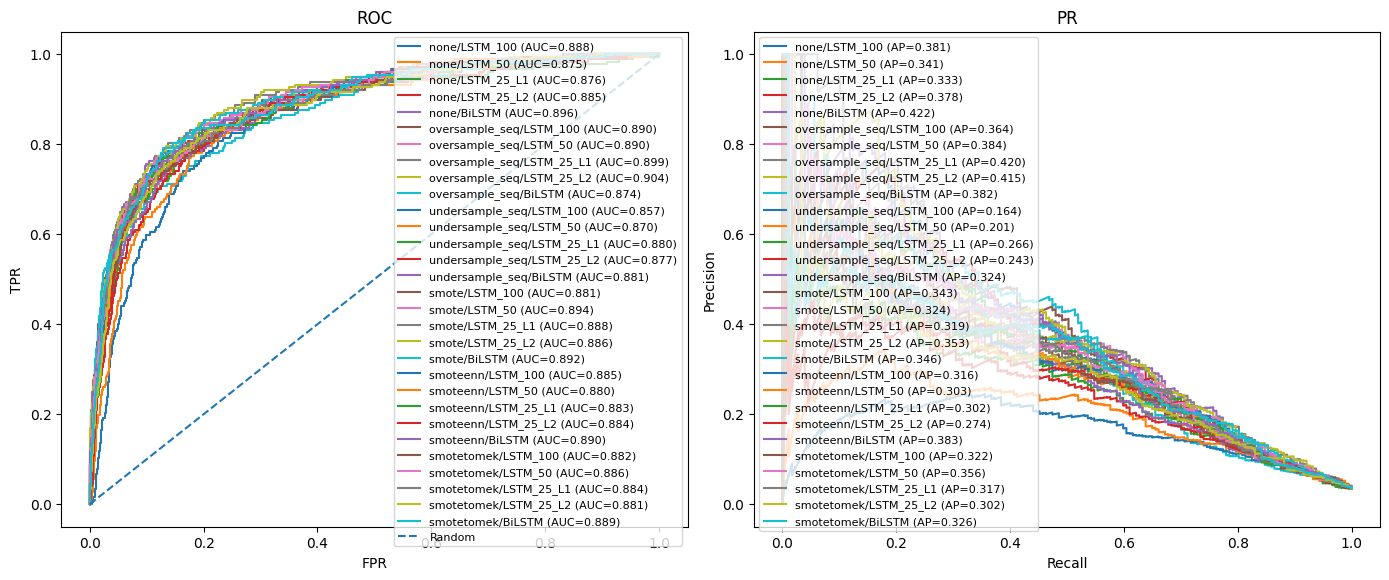


📁 Saved files:
 - plots/combined_roc_pr_curves.png
 - outputs/results_summary_all2.csv

Split counts:
Split
train           116
test            116
testBalanced    116
Name: count, dtype: int64

🔽 ORIGINAL TEST — top by Overall/F1_weighted
   Method       Model  Threshold  Overall/F1_weighted  \
49   none      BiLSTM       0.41               0.9633   
37   none  LSTM_25_L2       0.40               0.9630   
46   none      BiLSTM       0.40               0.9623   
52   none      BiLSTM       0.50               0.9623   
4    none    LSTM_100       0.41               0.9620   
1    none    LSTM_100       0.40               0.9619   
40   none  LSTM_25_L2       0.50               0.9613   
7    none    LSTM_100       0.50               0.9603   
25   none  LSTM_25_L1       0.40               0.9593   
28   none  LSTM_25_L1       0.41               0.9593   

    Overall/Recall_weighted  Overall/Precision_weighted  Overall/ROC-AUC  \
49                   0.9689                      0.9620

In [11]:
# ==============================================
# Leak-free Ramadan features + Balanced LSTM
# ==============================================

# (Optional) pin versions in Kaggle/Colab:
!pip install --upgrade pip
!pip install numpy==1.26.4 scipy==1.13.0 scikit-learn==1.5.1 imbalanced-learn==0.13.0 tensorflow==2.18.0 joblib==1.4.2

import os
import time
import warnings
warnings.filterwarnings("ignore")

import random
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve,
    average_precision_score, auc, mean_squared_error
)

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import joblib

# --------------------
# GLOBAL CONFIG
# --------------------
CSV_INTRADAY_WITH_VISITS = "/kaggle/input/hmcdataset/intraday_with_visits.csv"
CSV_INTRADAY_BASIC       = "/kaggle/input/hmcdataset/intraday.csv"

OUT_HOURLY_CSV = "/kaggle/working/dynamic_hourly_features_ramadan.csv"

RAMADAN_START = pd.to_datetime("2023-03-22")
RAMADAN_END   = pd.to_datetime("2023-04-19")
HYPO_CUTOFF   = 70.0          # mg/dL
MIN_CGM_PER_H = 4
SEQ_LEN       = 36            # hours per sequence window

# Columns you *might* have (safe–checked)
LIFESTYLE_COLS_CANDIDATES = [
    "steps","distance","calories","heart_rate","spo2",
    "deep","light","rem","nap","awake"
]

# Training config
RANDOM_STATE     = 42
THR_MIN, THR_MAX = 0.40, 0.60
AUGMENT_SIGMA    = 0.01  # small Gaussian jitter on train (optional); set None to disable
RESAMPLE_METHODS = [
    "none",           # baseline (class_weight + focal)
    "oversample_seq", # duplicate minority sequences
    "undersample_seq",# downsample majority sequences
    "smote",          # SMOTE on flattened sequences
    "smoteenn",       # SMOTE+ENN on flattened sequences
    "smotetomek"      # SMOTE+Tomek on flattened sequences
]

# --------------------
# General Utilities
# --------------------
def to_dt(x, utc_ok=True):
    return pd.to_datetime(x, errors="coerce", utc=utc_ok)

def ensure_numeric(df, exclude=("patientID","huaweiID","visit_assigned","period_main","start","date","hour","hour_of_day")):
    ex = set(exclude)
    for c in df.columns:
        if c not in ex:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def filter_ramadan(df):
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    return df[(df["date"] >= RAMADAN_START) & (df["date"] <= RAMADAN_END)].copy()

def set_global_seeds(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_global_seeds(RANDOM_STATE)

# ------------------------------------------------------
# Part A — Ramadan hourly features with leak-free PCA
# ------------------------------------------------------
def build_ramadan_hourly_features_leakfree(
    in_csv=CSV_INTRADAY_WITH_VISITS,
    out_csv=OUT_HOURLY_CSV,
    min_cgm_per_hour=MIN_CGM_PER_H,
    test_size=0.2,
    random_state=RANDOM_STATE,
    save_artifacts=True
):
    """
    Build Ramadan hourly features, splitting patients BEFORE any learned transform (scaling/PCA)
    to avoid leakage. Fits scalers/PCA on train patients only, then transforms test patients.

    Returns:
      hourly_out: combined DataFrame with engineered features (train+test concatenated)
      (train_pat, test_pat): tuple of patient ID arrays used for the split
    """
    if not os.path.exists(in_csv):
        raise FileNotFoundError(f"Input not found: {in_csv}")

    df = pd.read_csv(in_csv)

    # --- timestamps / numerics
    df["start"] = to_dt(df.get("start"))
    # Derive date if missing/unreliable
    if "date" not in df.columns or df["date"].isna().all():
        # Safe naive date regardless of tz
        df["date"] = pd.to_datetime(df["start"].dt.date)

    df["hour"] = df["start"].dt.floor("h")
    df["hour_of_day"] = df["hour"].dt.hour
    df = ensure_numeric(df)

    # --- Ramadan filter
    df = filter_ramadan(df)

    # --- require CGM
    if "cgm" not in df.columns:
        raise ValueError("❌ Dataset must include 'cgm' column.")
    df_cgm = df.dropna(subset=["cgm"]).copy()

    # --- only hours with enough CGM samples
    valid_hours = (
        df_cgm.groupby(["patientID","hour"])
              .filter(lambda g: g["cgm"].notna().sum() >= min_cgm_per_hour)
    )

    # --- base hourly CGM stats
    hourly = (
        valid_hours
        .groupby(["patientID","hour"], as_index=False)
        .agg(
            cgm_min=("cgm","min"),
            cgm_max=("cgm","max"),
            cgm_mean=("cgm","mean"),
            cgm_std=("cgm","std")
        )
        .sort_values(["patientID","hour"])
        .reset_index(drop=True)
    )
    hourly["hour_of_day"] = hourly["hour"].dt.hour

    # --- hypo label (any CGM < cutoff during the hour)
    lab = (
        valid_hours.groupby(["patientID","hour"])["cgm"]
        .apply(lambda x: int((x < HYPO_CUTOFF).any()))
        .reset_index(name="hypo_label")
    )
    hourly = hourly.merge(lab, on=["patientID","hour"], how="left")

    # --- composite CGM features
    hourly["cgm_mean_plus_std"]  = hourly["cgm_mean"] + hourly["cgm_std"]
    hourly["cgm_mean_minus_std"] = hourly["cgm_mean"] - hourly["cgm_std"]

    # --- optional lifestyle block
    lifestyle_cols = [c for c in LIFESTYLE_COLS_CANDIDATES if c in df_cgm.columns]
    if lifestyle_cols:
        life_hourly = (
            df_cgm.groupby(["patientID","hour"], as_index=False)[lifestyle_cols]
                  .mean()
                  .fillna(0.0)
        )
        hourly = hourly.merge(life_hourly, on=["patientID","hour"], how="left").fillna(0.0)
    else:
        hourly["pc1_activity_energy"] = 0.0
        hourly["pc2_physiology"]      = 0.0
        hourly["pc3_sleep_rest"]      = 0.0

    # --- split patients BEFORE PCA to avoid leakage
    unique_patients = hourly["patientID"].dropna().unique()
    train_pat, test_pat = train_test_split(unique_patients, test_size=test_size, random_state=random_state)
    train_df = hourly[hourly["patientID"].isin(train_pat)].copy()
    test_df  = hourly[hourly["patientID"].isin(test_pat)].copy()

    # --- fit CGM PCA on train only, transform both
    cgm_cols = ["cgm_min","cgm_max","cgm_mean","cgm_std"]
    scal_cgm = StandardScaler().fit(train_df[cgm_cols].fillna(0.0))
    pca_cgm  = PCA(n_components=3, random_state=random_state).fit(scal_cgm.transform(train_df[cgm_cols].fillna(0.0)))

    def _apply_cgm(df_in):
        X = scal_cgm.transform(df_in[cgm_cols].fillna(0.0))
        Z = pca_cgm.transform(X)
        out = df_in.copy()
        out["pca_cgm1"], out["pca_cgm2"], out["pca_cgm3"] = Z[:,0], Z[:,1], Z[:,2]
        return out

    train_df = _apply_cgm(train_df)
    test_df  = _apply_cgm(test_df)

    # --- lifestyle PCA (if present), also fit on train only
    if lifestyle_cols:
        scal_life = StandardScaler().fit(train_df[lifestyle_cols])
        pca_life  = PCA(n_components=3, random_state=random_state).fit(scal_life.transform(train_df[lifestyle_cols]))

        def _apply_life(df_in):
            X = scal_life.transform(df_in[lifestyle_cols])
            Z = pca_life.transform(X)
            out = df_in.copy()
            out["pc1_activity_energy"] = Z[:,0]
            out["pc2_physiology"]      = Z[:,1]
            out["pc3_sleep_rest"]      = Z[:,2]
            return out

        train_df = _apply_life(train_df)
        test_df  = _apply_life(test_df)

    # --- save & return (combined for convenience)
    hourly_out = pd.concat([train_df, test_df], axis=0).sort_values(["patientID","hour"]).reset_index(drop=True)
    hourly_out.to_csv(out_csv, index=False)
    print(f"✅ Saved leak‑free Ramadan hourly features to: {out_csv}")

    # Optionally save artifacts for reproducibility
    if save_artifacts:
        os.makedirs("/kaggle/working/artifacts", exist_ok=True)
        joblib.dump({"scal_cgm":scal_cgm, "pca_cgm":pca_cgm, "cols":cgm_cols},
                    "/kaggle/working/artifacts/cgm_pca.joblib")
        if lifestyle_cols:
            joblib.dump({"scal_life":scal_life, "pca_life":pca_life, "cols":lifestyle_cols},
                        "/kaggle/working/artifacts/life_pca.joblib")

    return hourly_out, (train_pat, test_pat)

# ------------------------------------------------------
# Part B — LSTM sequences from HOURLY CSV (supports PCs)
# ------------------------------------------------------
def build_lstm_sequences_from_hourly(
    hourly_df_or_path=OUT_HOURLY_CSV,
    seq_len=SEQ_LEN,
    feature_cols=("cgm_mean","cgm_std","pc1_activity_energy"),
    split_patients=None  # <-- (train_pat, test_pat)
):
    """
    Build sequences directly from the Ramadan hourly features CSV/DataFrame.
    Use this when you want columns like 'pc1_activity_energy', 'pca_cgm1', etc.
    Pass split_patients from the leak-free PCA step to avoid leakage.
    """
    if isinstance(hourly_df_or_path, (str, Path)):
        if not os.path.exists(hourly_df_or_path):
            raise FileNotFoundError(f"Hourly features not found: {hourly_df_or_path}")
        hourly = pd.read_csv(hourly_df_or_path)
    else:
        hourly = hourly_df_or_path.copy()

    req = {"patientID","hour","hypo_label"}
    missing = req - set(hourly.columns)
    if missing:
        raise KeyError(f"Hourly features missing required columns: {missing}")

    hourly["hour"] = pd.to_datetime(hourly["hour"], errors="coerce")
    feature_cols = list(feature_cols)
    miss = [c for c in feature_cols if c not in hourly.columns]
    if miss:
        raise KeyError(f"Requested feature(s) not found in hourly CSV: {miss}")

    hourly = hourly.sort_values(["patientID","hour"]).reset_index(drop=True)

    if split_patients is None:
        raise ValueError("Pass split_patients=(train_pat, test_pat) from the leak‑free PCA step.")
    train_pat, test_pat = split_patients
    train_df = hourly[hourly["patientID"].isin(train_pat)].copy()
    test_df  = hourly[hourly["patientID"].isin(test_pat)].copy()

    def build_sequences(df_in, feature_cols, label_col="hypo_label", seq_len=SEQ_LEN):
        X, y = [], []
        for pid, grp in df_in.groupby("patientID"):
            grp = grp.sort_values("hour").reset_index(drop=True)
            for i in range(len(grp) - seq_len):
                X.append(grp.loc[i:i+seq_len-1, feature_cols].values)
                y.append(int(grp.loc[i+seq_len, label_col]))
        return np.array(X), np.array(y)

    X_train, y_train = build_sequences(train_df, feature_cols, seq_len=seq_len)
    X_test,  y_test  = build_sequences(test_df,  feature_cols, seq_len=seq_len)

    print(f"✅ Sequences (Hourly/PCs, leak‑free) — train: {X_train.shape}, test: {X_test.shape} | features={feature_cols}")
    return (X_train, y_train, X_test, y_test), (train_df, test_df)

# ------------------------------------------------------
# Balanced LSTM pipeline utilities (metrics, resampling)
# ------------------------------------------------------
def _best_threshold_in_range(thresholds, scores, thr_min=THR_MIN, thr_max=THR_MAX):
    thresholds = np.asarray(thresholds, dtype=float)
    scores     = np.asarray(scores, dtype=float)
    mask = np.isfinite(thresholds) & (thresholds >= thr_min) & (thresholds <= thr_max)
    if mask.any():
        idx_in = int(np.nanargmax(scores[mask]))
        idx    = np.where(mask)[0][idx_in]
        return float(thresholds[idx]), True
    idx = int(np.nanargmax(scores))
    return float(np.clip(thresholds[idx], thr_min, thr_max)), False

def focal_loss(gamma=2.0, alpha=0.25):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
    eps = tf.keras.backend.epsilon()
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        ce = bce(y_true, y_pred)
        p_t = y_true * y_pred + (1.0 - y_true) * (1.0 - y_pred)
        alpha_t = y_true * alpha + (1.0 - y_true) * (1.0 - alpha)
        modulating = tf.pow(1.0 - p_t, gamma)
        return alpha_t * modulating * ce
    return loss

def _safe_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    if cm.shape != (2,2):
        full = np.zeros((2,2), dtype=int)
        full[:cm.shape[0], :cm.shape[1]] = cm
        cm = full
    return cm

def _specificity_overall(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return tn / (tn + fp + 1e-8)

def _specificity_per_class(y_true, y_pred, positive_label):
    # TNR for the "not positive_label" class, computed by binarizing on that label
    y_true_bin = (np.asarray(y_true).ravel() == positive_label).astype(int)
    y_pred_bin = (np.asarray(y_pred).ravel() == positive_label).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1]).ravel()
    return tn / (tn + fp + 1e-8)

def evaluate_full_metrics(y_true, y_pred, y_prob=None):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_pred = np.asarray(y_pred).astype(int).ravel()
    cm = _safe_confusion_matrix(y_true, y_pred)

    metrics = {}
    for lbl in [0,1]:
        metrics[f"Class{lbl}/Precision"]   = precision_score(y_true, y_pred, pos_label=lbl, zero_division=0)
        metrics[f"Class{lbl}/Recall"]      = recall_score(y_true, y_pred,    pos_label=lbl, zero_division=0)
        metrics[f"Class{lbl}/F1"]          = f1_score(y_true, y_pred,        pos_label=lbl, zero_division=0)
        metrics[f"Class{lbl}/Specificity"] = _specificity_per_class(y_true, y_pred, positive_label=lbl)
        metrics[f"Class{lbl}/Support"]     = int(np.sum(y_true == lbl))

    # overall (hard preds)
    metrics["Overall/Accuracy"]             = accuracy_score(y_true, y_pred)
    metrics["Overall/Precision_macro"]      = precision_score(y_true, y_pred, average='macro',    zero_division=0)
    metrics["Overall/Precision_weighted"]   = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics["Overall/Recall_macro"]         = recall_score(y_true, y_pred,    average='macro',    zero_division=0)
    metrics["Overall/Recall_weighted"]      = recall_score(y_true, y_pred,    average='weighted', zero_division=0)
    metrics["Overall/F1_macro"]             = f1_score(y_true, y_pred,        average='macro',    zero_division=0)
    metrics["Overall/F1_weighted"]          = f1_score(y_true, y_pred,        average='weighted', zero_division=0)
    metrics["Overall/Specificity"]          = _specificity_overall(y_true, y_pred)
    mse_pred                                = mean_squared_error(y_true, y_pred)
    metrics["Overall/MSE_pred"]             = mse_pred
    metrics["Overall/RMSE_pred"]            = float(np.sqrt(mse_pred))

    # prob-based
    if y_prob is not None:
        y_prob = np.asarray(y_prob, dtype=float).ravel()
        try:  metrics["Overall/ROC-AUC"] = roc_auc_score(y_true, y_prob)
        except ValueError: metrics["Overall/ROC-AUC"] = np.nan
        try:  metrics["Overall/PR-AUC"]  = average_precision_score(y_true, y_prob)
        except ValueError: metrics["Overall/PR-AUC"] = np.nan
        mse_prob                          = mean_squared_error(y_true, y_prob)
        metrics["Overall/MSE_prob"]       = mse_prob
        metrics["Overall/RMSE_prob"]      = float(np.sqrt(mse_prob))
    else:
        metrics["Overall/ROC-AUC"]  = np.nan
        metrics["Overall/PR-AUC"]   = np.nan
        metrics["Overall/MSE_prob"] = np.nan
        metrics["Overall/RMSE_prob"]= np.nan

    return metrics

def make_class_weight(y):
    y  = np.asarray(y).astype(int).ravel()
    n0 = max(1, (y==0).sum()); n1 = max(1, (y==1).sum()); N = n0+n1
    w0 = N/(2.0*n0); w1 = N/(2.0*n1)
    return {0: float(w0), 1: float(w1)}

def augment(X, y, sigma=AUGMENT_SIGMA):
    if sigma is None or sigma <= 0: 
        return X, y
    noise = np.random.normal(0, sigma, X.shape)
    return np.vstack([X, X+noise]), np.hstack([y, y])

def seq_resample(X, y, method="none", random_state=RANDOM_STATE):
    """
    Sequence-level resampling.
    method ∈ {
      "none",
      "oversample_seq", "undersample_seq",        # window-level (no interpolation)
      "smote", "smoteenn", "smotetomek"           # flattened window resampling
    }
    """
    X = np.asarray(X); y = np.asarray(y).astype(int).ravel()
    n, T, F = X.shape

    if method == "none":
        return X, y

    if method in {"oversample_seq","undersample_seq"}:
        rng = np.random.default_rng(random_state)
        idx0 = np.where(y==0)[0]; idx1 = np.where(y==1)[0]
        n0, n1 = len(idx0), len(idx1)
        if n0==0 or n1==0:
            return X, y

        if method == "oversample_seq":
            if n1 < n0:
                add = rng.choice(idx1, size=n0-n1, replace=True)
                keep = np.concatenate([idx0, idx1, add])
            else:
                add = rng.choice(idx0, size=n1-n0, replace=True)
                keep = np.concatenate([idx0, idx1, add])
        else:
            if n0 > n1:
                keep0 = rng.choice(idx0, size=n1, replace=False)
                keep  = np.concatenate([keep0, idx1])
            else:
                keep1 = rng.choice(idx1, size=n0, replace=False)
                keep  = np.concatenate([idx0, keep1])

        rng.shuffle(keep)
        return X[keep], y[keep]

    # SMOTE family on flattened sequences with guard
    Xf = X.reshape(n, -1)
    minority_n = int((y==1).sum())
    majority_n = int((y==0).sum())
    if minority_n < 2 or majority_n < 2:
        print("⚠️ Not enough samples for SMOTE/SMOTEENN/SMOTETomek; skipping resampling.")
        return X, y

    if method == "smote":
        k_neighbors = max(1, min(5, minority_n-1))
        sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        Xr, yr = sm.fit_resample(Xf, y)
    elif method == "smoteenn":
        Xr, yr = SMOTEENN(random_state=random_state).fit_resample(Xf, y)
    elif method == "smotetomek":
        Xr, yr = SMOTETomek(random_state=random_state).fit_resample(Xf, y)
    else:
        raise ValueError(f"Unknown resampling method: {method}")
    return Xr.reshape(-1, T, F), yr

def make_balanced_test(X_test, y_test, random_state=RANDOM_STATE):
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test).astype(int).ravel()
    idx0, idx1 = np.where(y_test==0)[0], np.where(y_test==1)[0]
    if len(idx0)==0 or len(idx1)==0: return X_test, y_test
    m = min(len(idx0), len(idx1))
    rs = np.random.RandomState(random_state)
    keep = np.concatenate([rs.choice(idx0, m, replace=False), rs.choice(idx1, m, replace=False)])
    rs.shuffle(keep)
    return X_test[keep], y_test[keep]

def define_models(input_shape):
    return {
        "LSTM_100": Sequential([
            Input(shape=input_shape),
            LSTM(100, return_sequences=True), Dropout(0.2),
            LSTM(50), Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_50": Sequential([
            Input(shape=input_shape),
            LSTM(50, return_sequences=True), Dropout(0.2),
            LSTM(25), Dropout(0.2),
            Dense(10, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_25_L1": Sequential([
            Input(shape=input_shape),
            LSTM(50, return_sequences=True, kernel_regularizer=l1(1e-5)), Dropout(0.2),
            LSTM(25, kernel_regularizer=l1(1e-5)), Dropout(0.2),
            Dense(10, activation='relu', kernel_regularizer=l1(1e-5)),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_25_L2": Sequential([
            Input(shape=input_shape),
            LSTM(50, return_sequences=True, kernel_regularizer=l2(1e-5)), Dropout(0.2),
            LSTM(25, kernel_regularizer=l2(1e-5)), Dropout(0.2),
            Dense(10, activation='relu', kernel_regularizer=l2(1e-5)),
            Dense(1, activation='sigmoid')
        ]),
        "BiLSTM": Sequential([
            Input(shape=input_shape),
            Bidirectional(LSTM(64, return_sequences=True)), Dropout(0.2),
            Bidirectional(LSTM(32)), Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
    }

def run_balanced_lstm_pipeline(X_train, y_train, X_test, y_test,
                               resample_methods=RESAMPLE_METHODS,
                               thr_min=THR_MIN, thr_max=THR_MAX,
                               random_state=RANDOM_STATE):
    """
    Trains all models across resampling methods, writes plots + CSV summary,
    and returns the results DataFrame.
    """
    os.makedirs("checkpoints", exist_ok=True)
    os.makedirs("plots", exist_ok=True)
    os.makedirs("outputs", exist_ok=True)

    # tiny augmentation (optional)
    X_train_aug, y_train_aug = augment(X_train, y_train, sigma=AUGMENT_SIGMA)

    # balanced test copy (for fair diagnostic read)
    X_test_bal, y_test_bal = make_balanced_test(X_test, y_test)

    results = {}       # key -> metrics dict
    roc_data = {}      # (method, model) -> (fpr, tpr, auc)
    pr_data  = {}      # (method, model) -> (recall, precision, ap)
    best_thresholds = {}  # (method, model) -> {"youden": t, "f1": t}

    def train_eval_one(method_name, model_name, model, Xtr, ytr, Xte, yte, XteB, yteB):
        tag = f"{method_name}__{model_name}"
        print(f"\n🚀 Training [{tag}] with class-weighted focal loss")
        es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
        cp = ModelCheckpoint(f"checkpoints/{tag}.h5", save_best_only=True, monitor='val_loss', verbose=0)
        model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

        class_weight = make_class_weight(ytr)
        t0 = time.time()
        model.fit(Xtr, ytr, epochs=5, batch_size=32,
                  validation_data=(Xte, yte),
                  callbacks=[es, cp], verbose=1,
                  class_weight=class_weight)
        print(f"⏱️ Training Time: {time.time()-t0:.2f}s")

        # probabilities
        p_tr  = model.predict(Xtr,  verbose=0).ravel()
        p_te  = model.predict(Xte,  verbose=0).ravel()
        p_teB = model.predict(XteB, verbose=0).ravel()

        # thresholds (on ORIGINAL test), constrained to [thr_min, thr_max]
        try:
            fpr, tpr, thr_roc = roc_curve(yte, p_te); auc_roc = auc(fpr, tpr)
        except ValueError:
            fpr, tpr, thr_roc, auc_roc = np.array([0,1]), np.array([0,1]), np.array([0.5]), np.nan
        youden = tpr - fpr
        t_roc, _ = _best_threshold_in_range(thr_roc, youden, thr_min, thr_max)

        prec, rec, thr_pr = precision_recall_curve(yte, p_te)
        f1s = 2*prec[:-1]*rec[:-1] / (prec[:-1]+rec[:-1]+1e-8)
        t_pr, _ = _best_threshold_in_range(thr_pr, f1s, thr_min, thr_max)
        ap_val  = average_precision_score(yte, p_te)

        roc_data[(method_name, model_name)] = (fpr, tpr, auc_roc)
        pr_data[(method_name, model_name)]  = (rec, prec, ap_val)
        best_thresholds[(method_name, model_name)] = {"youden": t_roc, "f1": t_pr}
        print(f"📌 [{tag}] thresholds → Youden={t_roc:.4f}, PR-F1={t_pr:.4f} (window [{thr_min},{thr_max}])")

        eval_ts = sorted(set([thr_min, 0.50, thr_max, float(t_roc), float(t_pr)]))
        # evaluate at all thresholds on train / test / testBalanced
        for t in eval_ts:
            yhat_tr  = (p_tr  >= t).astype(int)
            yhat_te  = (p_te  >= t).astype(int)
            yhat_teB = (p_teB >= t).astype(int)

            results[f"{tag}__thr_{t:.2f}__train"]         = evaluate_full_metrics(ytr,  yhat_tr,  p_tr)
            results[f"{tag}__thr_{t:.2f}__test"]          = evaluate_full_metrics(yte,  yhat_te,  p_te)
            results[f"{tag}__thr_{t:.2f}__testBalanced"]  = evaluate_full_metrics(yteB, yhat_teB, p_teB)

    # run all methods x models
    input_shape = (X_train_aug.shape[1], X_train_aug.shape[2])
    for METHOD in resample_methods:
        Xtr_rs, ytr_rs = seq_resample(X_train_aug, y_train_aug, method=METHOD, random_state=random_state)
        print(f"\n🔁 Resampling: {METHOD} → X={Xtr_rs.shape}, y={Counter(ytr_rs)}")
        for mname, model in define_models(input_shape).items():
            train_eval_one(METHOD, mname, model, Xtr_rs, ytr_rs, X_test, y_test, X_test_bal, y_test_bal)

    # --------------------------
    # Curves (optional plots)
    # --------------------------
    plt.figure(figsize=(14,6))
    # ROC
    plt.subplot(1,2,1)
    for (meth, mname), (fpr, tpr, auc_roc) in roc_data.items():
        plt.plot(fpr, tpr, label=f'{meth}/{mname} (AUC={auc_roc:.3f})')
    plt.plot([0,1],[0,1],'--',label='Random')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.legend(fontsize=8)
    # PR
    plt.subplot(1,2,2)
    for (meth, mname), (rec, prec, ap) in pr_data.items():
        plt.plot(rec, prec, label=f'{meth}/{mname} (AP={ap:.3f})')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR'); plt.legend(fontsize=8)
    plt.tight_layout(); plt.savefig("plots/combined_roc_pr_curves.png", dpi=300); plt.show()

    # --------------------------
    # Summaries
    # --------------------------
    results_df = pd.DataFrame(results).T
    results_df = results_df.reset_index().rename(columns={"index":"Key"})

    # Split extraction
    k = results_df["Key"].str.strip()
    split = np.where(k.str.endswith("__train"), "train",
             np.where(k.str.endswith("__testBalanced"), "testBalanced",
             np.where(k.str.endswith("__test"), "test", np.nan)))
    results_df["Split"] = split

    # Method, Model, Threshold extraction
    parts = k.str.split("__")
    results_df["Method"] = parts.str[0]
    results_df["Model"]  = parts.str[1]
    thr_str = parts.str[2].str.replace("thr_","", regex=False)
    with np.errstate(all='ignore'):
        results_df["Threshold"] = pd.to_numeric(thr_str, errors="coerce")

    # Save
    results_df.round(6).to_csv("outputs/results_summary_all2.csv", index=False)
    print("\n📁 Saved files:")
    print(" - plots/combined_roc_pr_curves.png")
    print(" - outputs/results_summary_all2.csv")

    # Quick sanity
    print("\nSplit counts:")
    print(results_df["Split"].value_counts(dropna=False))

    # Leaderboards
    eval_test_df  = results_df[results_df["Split"]=="test"].copy()
    eval_tbal_df  = results_df[results_df["Split"]=="testBalanced"].copy()

    def top_k(df, by_col, k=10, cols=None):
        if df.empty:
            return pd.DataFrame(columns=(cols or []))
        if cols is None:
            cols = ['Method','Model','Threshold','Overall/F1_weighted','Overall/Recall_weighted',
                    'Overall/Precision_weighted','Overall/ROC-AUC','Overall/PR-AUC','Overall/Accuracy']
        present = [c for c in cols if c in df.columns]
        return df.sort_values(by_col, ascending=False)[present].head(k).round(4)

    print("\n🔽 ORIGINAL TEST — top by Overall/F1_weighted")
    print(top_k(eval_test_df, 'Overall/F1_weighted'))

    print("\n🔽 BALANCED TEST — top by Overall/F1_weighted")
    print(top_k(eval_tbal_df, 'Overall/F1_weighted'))

    def best_per_model(df):
        if df.empty:
            return df
        idx = df.groupby(['Method','Model'])['Overall/F1_weighted'].idxmax()
        return df.loc[idx].sort_values(['Overall/F1_weighted'], ascending=False)

    overall_cols = [
        'Overall/Accuracy','Overall/Precision_macro','Overall/Recall_macro','Overall/F1_macro',
        'Overall/Precision_weighted','Overall/Recall_weighted','Overall/F1_weighted',
        'Overall/Specificity','Overall/ROC-AUC','Overall/PR-AUC',
        'Overall/MSE_pred','Overall/RMSE_pred','Overall/MSE_prob','Overall/RMSE_prob'
    ]
    class_cols = [
        'Class0/Precision','Class0/Recall','Class0/F1','Class0/Specificity','Class0/Support',
        'Class1/Precision','Class1/Recall','Class1/F1','Class1/Specificity','Class1/Support'
    ]

    print("\n=== ORIGINAL TEST — best per (Method,Model) ===")
    best_test = best_per_model(eval_test_df)
    if best_test.empty:
        print("⚠️ No TEST rows found — check Split counts above.")
    else:
        print(best_test[['Method','Model','Threshold']+[c for c in overall_cols if c in best_test.columns]].round(4))
        print("\n--- Per-class breakdown:")
        print(best_test[['Method','Model','Threshold']+[c for c in class_cols if c in best_test.columns]].round(4))

    print("\n=== BALANCED TEST — best per (Method,Model) ===")
    best_tbal = best_per_model(eval_tbal_df)
    if best_tbal.empty:
        print("⚠️ No BALANCED TEST rows found — check Split counts above.")
    else:
        print(best_tbal[['Method','Model','Threshold']+[c for c in overall_cols if c in best_tbal.columns]].round(4))
        print("\n--- Per-class breakdown:")
        print(best_tbal[['Method','Model','Threshold']+[c for c in class_cols if c in best_tbal.columns]].round(4))

    return results_df

# ------------------------------------------------------
# CGM-only (raw intraday) sequence builder
# ------------------------------------------------------
def build_cgm_only_sequences_from_intraday(
    in_csv=CSV_INTRADAY_BASIC,
    seq_len=SEQ_LEN,
    label_cutoff=HYPO_CUTOFF,
    min_cgm_per_hour=MIN_CGM_PER_H,
    feature_cols=("cgm_mean",),  # customize: ("cgm_mean","cgm_std","cgm_min","cgm_max")
    test_size=0.3,
    random_state=RANDOM_STATE
):
    """
    Build CGM-only hourly features from intraday and convert to sequences.
    Splits by patient to avoid leakage.
    """
    if not os.path.exists(in_csv):
        raise FileNotFoundError(f"Input not found: {in_csv}")

    df = pd.read_csv(in_csv)
    df["start"] = to_dt(df.get("start"))
    df["hour"]  = df["start"].dt.floor("h")

    base = df[["patientID","hour","cgm"]].dropna(subset=["cgm"])
    valid = base.groupby(["patientID","hour"]).filter(lambda g: g["cgm"].notna().sum() >= min_cgm_per_hour)

    feats = (
        valid.groupby(["patientID","hour"])
             .agg(
                 cgm_std=("cgm","std"),
                 cgm_min=("cgm","min"),
                 cgm_mean=("cgm","mean"),
                 cgm_max=("cgm","max"),
                 hypo_label=("cgm", lambda x: int((x < label_cutoff).any()))
             )
             .reset_index()
             .sort_values(["patientID","hour"])
             .reset_index(drop=True)
    )

    # leakage-proof split
    unique_patients = feats["patientID"].unique()
    train_pat, test_pat = train_test_split(unique_patients, test_size=test_size, random_state=random_state)
    train_df = feats[feats["patientID"].isin(train_pat)].copy()
    test_df  = feats[feats["patientID"].isin(test_pat)].copy()

    feature_cols = list(feature_cols)
    for col in feature_cols + ["hypo_label"]:
        if col not in feats.columns:
            raise KeyError(f"Column '{col}' not found. Available: {feats.columns.tolist()}")

    def build_sequences(df_in, feature_cols, label_col="hypo_label", seq_len=seq_len):
        X, y = [], []
        for pid, grp in df_in.groupby("patientID"):
            grp = grp.sort_values("hour").reset_index(drop=True)
            for i in range(len(grp) - seq_len):
                X.append(grp.loc[i:i+seq_len-1, feature_cols].values)
                y.append(int(grp.loc[i+seq_len, label_col]))
        return np.array(X), np.array(y)

    X_train, y_train = build_sequences(train_df, feature_cols)
    X_test,  y_test  = build_sequences(test_df,  feature_cols)

    print(f"✅ Sequences (CGM-only) — train: {X_train.shape}, test: {X_test.shape} | features={feature_cols}")
    return (X_train, y_train, X_test, y_test), (train_df, test_df)

# ------------------------------------------------------
# Main control flags
# ------------------------------------------------------
RUN_FEATURE_BUILD          = False  # Build Ramadan hourly features + leak-free PCA
RUN_TRAINING_FROM_HOURLY   = True  # Train models using sequences built from hourly features
RUN_TRAINING_FROM_CGM_ONLY = False  # Train models using CGM-only sequences from raw intraday

# ------------------------------------------------------
# Orchestrate
# ------------------------------------------------------
if __name__ == "__main__":
    hourly_features = None
    split_pat       = None

    # Part A: Ramadan hourly features with leak-free PCA
    if RUN_FEATURE_BUILD or RUN_TRAINING_FROM_HOURLY:
        try:
            hourly_features, split_pat = build_ramadan_hourly_features_leakfree(
                in_csv=CSV_INTRADAY_WITH_VISITS,
                out_csv=OUT_HOURLY_CSV,
                min_cgm_per_hour=MIN_CGM_PER_H,
                test_size=0.3,
                random_state=RANDOM_STATE
            )
        except Exception as e:
            print(f"[WARN] Skipping Ramadan feature build: {e}")

    # Part B option 1 — Train from HOURLY (PC) sequences
    if RUN_TRAINING_FROM_HOURLY:
        try:
            if split_pat is None:
                raise RuntimeError("No patient split found. Ensure feature build step ran successfully.")
            (X_train, y_train, X_test, y_test), _ = build_lstm_sequences_from_hourly(
                hourly_df_or_path=OUT_HOURLY_CSV,
                seq_len=SEQ_LEN,
                feature_cols=("cgm_mean","cgm_std","pc1_activity_energy"),
                split_patients=split_pat
            )
            _ = run_balanced_lstm_pipeline(X_train, y_train, X_test, y_test)
        except Exception as e:
            print(f"[WARN] Skipping hourly-based training: {e}")

    # Part B option 2 — Train from CGM-only (raw intraday) sequences
    if RUN_TRAINING_FROM_CGM_ONLY:
        try:
            (X_train_cgm, y_train_cgm, X_test_cgm, y_test_cgm), _ = build_cgm_only_sequences_from_intraday(
                in_csv=CSV_INTRADAY_BASIC,
                seq_len=SEQ_LEN,
                label_cutoff=HYPO_CUTOFF,
                min_cgm_per_hour=MIN_CGM_PER_H,
                feature_cols=("cgm_mean",)  # or: ("cgm_mean","cgm_std","cgm_min","cgm_max")
            )
            _ = run_balanced_lstm_pipeline(X_train_cgm, y_train_cgm, X_test_cgm, y_test_cgm)
        except Exception as e:
            print(f"[WARN] Skipping CGM-only training: {e}")


✅ Saved leak‑free Ramadan hourly features to: /kaggle/working/dynamic_hourly_features_ramadan.csv
✅ Sequences (Hourly/ALL_FEATURES, leak‑free) — train: (13351, 36, 12), test: (5148, 36, 12) | features=['cgm_min', 'cgm_max', 'cgm_mean', 'cgm_std', 'cgm_mean_plus_std', 'cgm_mean_minus_std', 'pca_cgm1', 'pca_cgm2', 'pca_cgm3', 'pc1_activity_energy', 'pc2_physiology', 'pc3_sleep_rest']

🔁 Resampling: none → X=(26702, 36, 12), y=Counter({0: 25422, 1: 1280})

🚀 Training [none__LSTM_100] with class-weighted focal loss
Epoch 1/5
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9447 - loss: 0.0262

835/835 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9448 - loss: 0.0262 - val_accuracy: 0.9656 - val_loss: 0.0024
Epoch 2/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9509 - loss: 0.0180

835/835 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9509 - loss: 0.0180 - val_accuracy: 0.9656 - val_loss: 0.0021
Epoch 3/5
831/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9522 - loss: 0.0168

835/835 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9523 - loss: 0.0168 - val_accuracy: 0.9678 - val_loss: 0.0020
Epoch 4/5
832/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9540 - loss: 0.0166

835/835 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9540 - loss: 0.0166 - val_accuracy: 0.9699 - val_loss: 0.0019
Epoch 5/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9554 - loss: 0.0160 - val_accuracy: 0.9701 - val_loss: 0.0021
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 41.01s
📌 [none__LSTM_100] thresholds → Youden=0.4055, PR-F1=0.4055 (window [0.4,0.6])

🚀 Training [none__LSTM_50] with class-weighted focal loss
Epoch 1/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9446 - loss: 0.0308

835/835 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9446 - loss: 0.0308 - val_accuracy: 0.9656 - val_loss: 0.0031
Epoch 2/5
830/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9509 - loss: 0.0205

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9509 - loss: 0.0205 - val_accuracy: 0.9656 - val_loss: 0.0026
Epoch 3/5
833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9509 - loss: 0.0183

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9509 - loss: 0.0183 - val_accuracy: 0.9654 - val_loss: 0.0022
Epoch 4/5
833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9513 - loss: 0.0171

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9513 - loss: 0.0171 - val_accuracy: 0.9676 - val_loss: 0.0020
Epoch 5/5
830/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9530 - loss: 0.0165

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9531 - loss: 0.0164 - val_accuracy: 0.9689 - val_loss: 0.0020
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 39.07s
📌 [none__LSTM_50] thresholds → Youden=0.4065, PR-F1=0.4053 (window [0.4,0.6])

🚀 Training [none__LSTM_25_L1] with class-weighted focal loss
Epoch 1/5
832/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9509 - loss: 0.0302

835/835 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9509 - loss: 0.0302 - val_accuracy: 0.9656 - val_loss: 0.0050
Epoch 2/5
832/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9509 - loss: 0.0229

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9509 - loss: 0.0229 - val_accuracy: 0.9656 - val_loss: 0.0047
Epoch 3/5
829/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9511 - loss: 0.0217

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9511 - loss: 0.0217 - val_accuracy: 0.9656 - val_loss: 0.0043
Epoch 4/5
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9525 - loss: 0.0197

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9525 - loss: 0.0197 - val_accuracy: 0.9656 - val_loss: 0.0038
Epoch 5/5
833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9519 - loss: 0.0201

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9519 - loss: 0.0201 - val_accuracy: 0.9658 - val_loss: 0.0034
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 39.44s
📌 [none__LSTM_25_L1] thresholds → Youden=0.4043, PR-F1=0.4014 (window [0.4,0.6])

🚀 Training [none__LSTM_25_L2] with class-weighted focal loss
Epoch 1/5
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9498 - loss: 0.0274

835/835 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9498 - loss: 0.0274 - val_accuracy: 0.9656 - val_loss: 0.0033
Epoch 2/5
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9509 - loss: 0.0205

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9509 - loss: 0.0205 - val_accuracy: 0.9656 - val_loss: 0.0031
Epoch 3/5
832/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9510 - loss: 0.0195

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9510 - loss: 0.0195 - val_accuracy: 0.9656 - val_loss: 0.0030
Epoch 4/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9509 - loss: 0.0189 - val_accuracy: 0.9656 - val_loss: 0.0031
Epoch 5/5
830/835 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9517 - loss: 0.0186

835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9517 - loss: 0.0186 - val_accuracy: 0.9656 - val_loss: 0.0027
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 39.40s
📌 [none__LSTM_25_L2] thresholds → Youden=0.4026, PR-F1=0.4026 (window [0.4,0.6])

🚀 Training [none__BiLSTM] with class-weighted focal loss
Epoch 1/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9471 - loss: 0.0265

835/835 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9471 - loss: 0.0265 - val_accuracy: 0.9656 - val_loss: 0.0025
Epoch 2/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9512 - loss: 0.0189

835/835 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9512 - loss: 0.0189 - val_accuracy: 0.9662 - val_loss: 0.0023
Epoch 3/5
832/835 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9528 - loss: 0.0167

835/835 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9528 - loss: 0.0167 - val_accuracy: 0.9693 - val_loss: 0.0019
Epoch 4/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9558 - loss: 0.0161 - val_accuracy: 0.9705 - val_loss: 0.0020
Epoch 5/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9550 - loss: 0.0154 - val_accuracy: 0.9699 - val_loss: 0.0021
Restoring model weights from the end of the best epoch: 3.
⏱️ Training Time: 60.97s
📌 [none__BiLSTM] thresholds → Youden=0.4008, PR-F1=0.4008 (window [0.4,0.6])

🔁 Resampling: oversample_seq → X=(50844, 36, 12), y=Counter({1: 25422, 0: 25422})

🚀 Training [oversample_seq__LSTM_100] with class-weighted focal loss
Epoch 1/5
1584/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7479 - loss: 0.0356

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7480 - loss: 0.0356 - val_accuracy: 0.9089 - val_loss: 0.0210
Epoch 2/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8071 - loss: 0.0241 - val_accuracy: 0.8735 - val_loss: 0.0343
Epoch 3/5
1587/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8177 - loss: 0.0226

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8177 - loss: 0.0226 - val_accuracy: 0.9192 - val_loss: 0.0196
Epoch 4/5
1585/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8208 - loss: 0.0218

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8208 - loss: 0.0218 - val_accuracy: 0.9192 - val_loss: 0.0195
Epoch 5/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8247 - loss: 0.0205 - val_accuracy: 0.9013 - val_loss: 0.0230
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 69.66s
📌 [oversample_seq__LSTM_100] thresholds → Youden=0.4134, PR-F1=0.5986 (window [0.4,0.6])

🚀 Training [oversample_seq__LSTM_50] with class-weighted focal loss
Epoch 1/5
1584/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7191 - loss: 0.0407

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7192 - loss: 0.0407 - val_accuracy: 0.8856 - val_loss: 0.0242
Epoch 2/5
1587/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8059 - loss: 0.0256

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8059 - loss: 0.0256 - val_accuracy: 0.9089 - val_loss: 0.0218
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8104 - loss: 0.0237 - val_accuracy: 0.8840 - val_loss: 0.0327
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8121 - loss: 0.0229 - val_accuracy: 0.9035 - val_loss: 0.0230
Epoch 5/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8203 - loss: 0.0215 - val_accuracy: 0.9110 - val_loss: 0.0218
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
⏱️ Training Time: 67.70s
📌 [oversample_seq__LSTM_50] thresholds → Youden=0.4162, PR-F1=0.5982 (window [0.4,0.6])

🚀 Training [oversample_seq__LSTM_25_L1] with class-weighted focal loss
Epoch 1/5
1588/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7144 - loss: 0.0452

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7144 - loss: 0.0452 - val_accuracy: 0.8706 - val_loss: 0.0313
Epoch 2/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8014 - loss: 0.0291

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8014 - loss: 0.0291 - val_accuracy: 0.8976 - val_loss: 0.0290
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8064 - loss: 0.0272 - val_accuracy: 0.8868 - val_loss: 0.0296
Epoch 4/5
1585/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8086 - loss: 0.0265

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8086 - loss: 0.0265 - val_accuracy: 0.9114 - val_loss: 0.0246
Epoch 5/5
1588/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8157 - loss: 0.0249

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8157 - loss: 0.0249 - val_accuracy: 0.9233 - val_loss: 0.0224
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 68.99s
📌 [oversample_seq__LSTM_25_L1] thresholds → Youden=0.4193, PR-F1=0.6000 (window [0.4,0.6])

🚀 Training [oversample_seq__LSTM_25_L2] with class-weighted focal loss
Epoch 1/5
1587/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7114 - loss: 0.0413

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7115 - loss: 0.0413 - val_accuracy: 0.8745 - val_loss: 0.0297
Epoch 2/5
1584/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8052 - loss: 0.0264

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8052 - loss: 0.0264 - val_accuracy: 0.9033 - val_loss: 0.0214
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8087 - loss: 0.0254 - val_accuracy: 0.8928 - val_loss: 0.0284
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8104 - loss: 0.0245 - val_accuracy: 0.9064 - val_loss: 0.0231
Epoch 5/5
1583/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8199 - loss: 0.0233

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8199 - loss: 0.0233 - val_accuracy: 0.9200 - val_loss: 0.0176
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 68.01s
📌 [oversample_seq__LSTM_25_L2] thresholds → Youden=0.4487, PR-F1=0.5996 (window [0.4,0.6])

🚀 Training [oversample_seq__BiLSTM] with class-weighted focal loss
Epoch 1/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7342 - loss: 0.0381

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.7342 - loss: 0.0381 - val_accuracy: 0.9025 - val_loss: 0.0216
Epoch 2/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.8142 - loss: 0.0236 - val_accuracy: 0.9005 - val_loss: 0.0225
Epoch 3/5
1586/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8186 - loss: 0.0223

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8186 - loss: 0.0223 - val_accuracy: 0.9037 - val_loss: 0.0211
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8185 - loss: 0.0221

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8185 - loss: 0.0221 - val_accuracy: 0.9262 - val_loss: 0.0164
Epoch 5/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.8265 - loss: 0.0207 - val_accuracy: 0.9143 - val_loss: 0.0178
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 102.11s
📌 [oversample_seq__BiLSTM] thresholds → Youden=0.4805, PR-F1=0.5989 (window [0.4,0.6])

🔁 Resampling: undersample_seq → X=(2560, 36, 12), y=Counter({1: 1280, 0: 1280})

🚀 Training [undersample_seq__LSTM_100] with class-weighted focal loss
Epoch 1/5
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5379 - loss: 0.0640

80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5410 - loss: 0.0636 - val_accuracy: 0.8118 - val_loss: 0.0479
Epoch 2/5
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7480 - loss: 0.0392

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7486 - loss: 0.0390 - val_accuracy: 0.8947 - val_loss: 0.0174
Epoch 3/5
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7703 - loss: 0.0345

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7708 - loss: 0.0344 - val_accuracy: 0.9066 - val_loss: 0.0154
Epoch 4/5
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7766 - loss: 0.0329

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7769 - loss: 0.0328 - val_accuracy: 0.9184 - val_loss: 0.0118
Epoch 5/5
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7663 - loss: 0.0311

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7669 - loss: 0.0310 - val_accuracy: 0.9415 - val_loss: 0.0088
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 9.11s
📌 [undersample_seq__LSTM_100] thresholds → Youden=0.4027, PR-F1=0.5339 (window [0.4,0.6])

🚀 Training [undersample_seq__LSTM_50] with class-weighted focal loss
Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5038 - loss: 0.0697

80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5042 - loss: 0.0696 - val_accuracy: 0.8840 - val_loss: 0.0350
Epoch 2/5
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6743 - loss: 0.0466

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6751 - loss: 0.0465 - val_accuracy: 0.8755 - val_loss: 0.0239
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7363 - loss: 0.0385

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7365 - loss: 0.0385 - val_accuracy: 0.8972 - val_loss: 0.0183
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7612 - loss: 0.0343

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7613 - loss: 0.0343 - val_accuracy: 0.9089 - val_loss: 0.0153
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7729 - loss: 0.0337 - val_accuracy: 0.9054 - val_loss: 0.0165
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 8.62s
📌 [undersample_seq__LSTM_50] thresholds → Youden=0.4363, PR-F1=0.5337 (window [0.4,0.6])

🚀 Training [undersample_seq__LSTM_25_L1] with class-weighted focal loss
Epoch 1/5
73/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4990 - loss: 0.0919

80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4991 - loss: 0.0909 - val_accuracy: 0.9656 - val_loss: 0.0400
Epoch 2/5
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5871 - loss: 0.0630

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5900 - loss: 0.0626 - val_accuracy: 0.8724 - val_loss: 0.0340
Epoch 3/5
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7244 - loss: 0.0443

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7249 - loss: 0.0442 - val_accuracy: 0.8803 - val_loss: 0.0234
Epoch 4/5
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7379 - loss: 0.0452

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7387 - loss: 0.0450 - val_accuracy: 0.9017 - val_loss: 0.0182
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7629 - loss: 0.0397 - val_accuracy: 0.8801 - val_loss: 0.0254
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 9.04s
📌 [undersample_seq__LSTM_25_L1] thresholds → Youden=0.4599, PR-F1=0.5928 (window [0.4,0.6])

🚀 Training [undersample_seq__LSTM_25_L2] with class-weighted focal loss
Epoch 1/5
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5510 - loss: 0.0638

80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5533 - loss: 0.0635 - val_accuracy: 0.8537 - val_loss: 0.0364
Epoch 2/5
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7084 - loss: 0.0455

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7097 - loss: 0.0453 - val_accuracy: 0.8462 - val_loss: 0.0329
Epoch 3/5
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7513 - loss: 0.0384

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7520 - loss: 0.0383 - val_accuracy: 0.8776 - val_loss: 0.0247
Epoch 4/5
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7666 - loss: 0.0351

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7668 - loss: 0.0351 - val_accuracy: 0.9141 - val_loss: 0.0144
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7703 - loss: 0.0345 - val_accuracy: 0.9011 - val_loss: 0.0175
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 8.87s
📌 [undersample_seq__LSTM_25_L2] thresholds → Youden=0.4004, PR-F1=0.5786 (window [0.4,0.6])

🚀 Training [undersample_seq__BiLSTM] with class-weighted focal loss
Epoch 1/5
76/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5506 - loss: 0.0633

80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5548 - loss: 0.0627 - val_accuracy: 0.8182 - val_loss: 0.0430
Epoch 2/5
76/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7357 - loss: 0.0408

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7365 - loss: 0.0406 - val_accuracy: 0.8599 - val_loss: 0.0268
Epoch 3/5
76/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7576 - loss: 0.0357

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7583 - loss: 0.0355 - val_accuracy: 0.9031 - val_loss: 0.0181
Epoch 4/5
76/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7718 - loss: 0.0322

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7724 - loss: 0.0320 - val_accuracy: 0.9169 - val_loss: 0.0133
Epoch 5/5
76/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7706 - loss: 0.0324

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7718 - loss: 0.0322 - val_accuracy: 0.9338 - val_loss: 0.0095
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 13.39s
📌 [undersample_seq__BiLSTM] thresholds → Youden=0.4009, PR-F1=0.5870 (window [0.4,0.6])

🔁 Resampling: smote → X=(50844, 36, 12), y=Counter({0: 25422, 1: 25422})

🚀 Training [smote__LSTM_100] with class-weighted focal loss
Epoch 1/5
1587/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7533 - loss: 0.0339

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7534 - loss: 0.0339 - val_accuracy: 0.9413 - val_loss: 0.0084
Epoch 2/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8288 - loss: 0.0200 - val_accuracy: 0.9343 - val_loss: 0.0103
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8452 - loss: 0.0172 - val_accuracy: 0.8918 - val_loss: 0.0210
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8489 - loss: 0.0161 - val_accuracy: 0.9157 - val_loss: 0.0164
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
⏱️ Training Time: 59.36s
📌 [smote__LSTM_100] thresholds → Youden=0.4243, PR-F1=0.5748 (window [0.4,0.6])

🚀 Training [smote__LSTM_50] with class-weighted focal loss
Epoch 1/5
1585/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7030 - loss: 0.0425

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7032 - loss: 0.0425 - val_accuracy: 0.9167 - val_loss: 0.0132
Epoch 2/5
1587/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8171 - loss: 0.0235

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8171 - loss: 0.0235 - val_accuracy: 0.9167 - val_loss: 0.0125
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8366 - loss: 0.0194 - val_accuracy: 0.8883 - val_loss: 0.0231
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8443 - loss: 0.0181 - val_accuracy: 0.9110 - val_loss: 0.0170
Epoch 5/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8495 - loss: 0.0169 - val_accuracy: 0.9110 - val_loss: 0.0155
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
⏱️ Training Time: 68.51s
📌 [smote__LSTM_50] thresholds → Youden=0.4195, PR-F1=0.5992 (window [0.4,0.6])

🚀 Training [smote__LSTM_25_L1] with class-weighted focal loss
Epoch 1/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7168 - loss: 0.0435

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7169 - loss: 0.0435 - val_accuracy: 0.9029 - val_loss: 0.0186
Epoch 2/5
1584/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8194 - loss: 0.0259

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8194 - loss: 0.0259 - val_accuracy: 0.9167 - val_loss: 0.0165
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8279 - loss: 0.0234 - val_accuracy: 0.9048 - val_loss: 0.0182
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8428 - loss: 0.0203 - val_accuracy: 0.8800 - val_loss: 0.0254
Epoch 5/5
1585/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8446 - loss: 0.0195

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8446 - loss: 0.0195 - val_accuracy: 0.9402 - val_loss: 0.0089
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 69.39s
📌 [smote__LSTM_25_L1] thresholds → Youden=0.4045, PR-F1=0.5975 (window [0.4,0.6])

🚀 Training [smote__LSTM_25_L2] with class-weighted focal loss
Epoch 1/5
1585/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7185 - loss: 0.0407

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7187 - loss: 0.0407 - val_accuracy: 0.9285 - val_loss: 0.0117
Epoch 2/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8121 - loss: 0.0243 - val_accuracy: 0.9003 - val_loss: 0.0213
Epoch 3/5
1588/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8189 - loss: 0.0226

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8189 - loss: 0.0226 - val_accuracy: 0.9316 - val_loss: 0.0112
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8333 - loss: 0.0202 - val_accuracy: 0.9225 - val_loss: 0.0167
Epoch 5/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8391 - loss: 0.0190 - val_accuracy: 0.8980 - val_loss: 0.0193
Restoring model weights from the end of the best epoch: 3.
⏱️ Training Time: 69.99s
📌 [smote__LSTM_25_L2] thresholds → Youden=0.4360, PR-F1=0.5997 (window [0.4,0.6])

🚀 Training [smote__BiLSTM] with class-weighted focal loss
Epoch 1/5
1586/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7472 - loss: 0.0358

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.7473 - loss: 0.0358 - val_accuracy: 0.9289 - val_loss: 0.0108
Epoch 2/5
1588/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8304 - loss: 0.0209

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8304 - loss: 0.0209 - val_accuracy: 0.9406 - val_loss: 0.0095
Epoch 3/5
1586/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8327 - loss: 0.0195

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8327 - loss: 0.0195 - val_accuracy: 0.9357 - val_loss: 0.0094
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8400 - loss: 0.0180 - val_accuracy: 0.9174 - val_loss: 0.0154
Epoch 5/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8473 - loss: 0.0168 - val_accuracy: 0.9174 - val_loss: 0.0165
Restoring model weights from the end of the best epoch: 3.
⏱️ Training Time: 106.40s
📌 [smote__BiLSTM] thresholds → Youden=0.5107, PR-F1=0.5749 (window [0.4,0.6])

🔁 Resampling: smoteenn → X=(47858, 36, 12), y=Counter({1: 25422, 0: 22436})

🚀 Training [smoteenn__LSTM_100] with class-weighted focal loss
Epoch 1/5
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7652 - loss: 0.0316

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7653 - loss: 0.0316 - val_accuracy: 0.8652 - val_loss: 0.0329
Epoch 2/5
1492/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8330 - loss: 0.0184

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8330 - loss: 0.0184 - val_accuracy: 0.8901 - val_loss: 0.0285
Epoch 3/5
1492/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8418 - loss: 0.0167

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8418 - loss: 0.0167 - val_accuracy: 0.8986 - val_loss: 0.0247
Epoch 4/5
1490/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8525 - loss: 0.0151

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8525 - loss: 0.0151 - val_accuracy: 0.9027 - val_loss: 0.0224
Epoch 5/5
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8633 - loss: 0.0133 - val_accuracy: 0.8405 - val_loss: 0.0481
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 66.08s
📌 [smoteenn__LSTM_100] thresholds → Youden=0.4018, PR-F1=0.5895 (window [0.4,0.6])

🚀 Training [smoteenn__LSTM_50] with class-weighted focal loss
Epoch 1/5
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7143 - loss: 0.0403

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7144 - loss: 0.0403 - val_accuracy: 0.8644 - val_loss: 0.0353
Epoch 2/5
1495/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8202 - loss: 0.0216

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8203 - loss: 0.0216 - val_accuracy: 0.8959 - val_loss: 0.0213
Epoch 3/5
1495/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8315 - loss: 0.0192

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8315 - loss: 0.0192 - val_accuracy: 0.9017 - val_loss: 0.0211
Epoch 4/5
1490/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8423 - loss: 0.0172

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8423 - loss: 0.0172 - val_accuracy: 0.9085 - val_loss: 0.0177
Epoch 5/5
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8569 - loss: 0.0148 - val_accuracy: 0.8666 - val_loss: 0.0339
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 64.02s
📌 [smoteenn__LSTM_50] thresholds → Youden=0.5111, PR-F1=0.5994 (window [0.4,0.6])

🚀 Training [smoteenn__LSTM_25_L1] with class-weighted focal loss
Epoch 1/5
1491/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7049 - loss: 0.0437

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7051 - loss: 0.0436 - val_accuracy: 0.8869 - val_loss: 0.0272
Epoch 2/5
1490/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8175 - loss: 0.0248

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8175 - loss: 0.0248 - val_accuracy: 0.8922 - val_loss: 0.0249
Epoch 3/5
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8227 - loss: 0.0228 - val_accuracy: 0.8834 - val_loss: 0.0293
Epoch 4/5
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8146 - loss: 0.0240 - val_accuracy: 0.8718 - val_loss: 0.0288
Epoch 5/5
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8319 - loss: 0.0206

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8319 - loss: 0.0206 - val_accuracy: 0.9031 - val_loss: 0.0205
Restoring model weights from the end of the best epoch: 5.
⏱️ Training Time: 66.00s
📌 [smoteenn__LSTM_25_L1] thresholds → Youden=0.5619, PR-F1=0.5978 (window [0.4,0.6])

🚀 Training [smoteenn__LSTM_25_L2] with class-weighted focal loss
Epoch 1/5
1495/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7282 - loss: 0.0388

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7282 - loss: 0.0388 - val_accuracy: 0.8916 - val_loss: 0.0248
Epoch 2/5
1491/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8189 - loss: 0.0220

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8189 - loss: 0.0220 - val_accuracy: 0.8883 - val_loss: 0.0244
Epoch 3/5
1493/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8229 - loss: 0.0210

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8229 - loss: 0.0210 - val_accuracy: 0.9184 - val_loss: 0.0170
Epoch 4/5
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8250 - loss: 0.0209 - val_accuracy: 0.9075 - val_loss: 0.0196
Epoch 5/5
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8283 - loss: 0.0204 - val_accuracy: 0.9128 - val_loss: 0.0190
Restoring model weights from the end of the best epoch: 3.
⏱️ Training Time: 64.92s
📌 [smoteenn__LSTM_25_L2] thresholds → Youden=0.4630, PR-F1=0.5956 (window [0.4,0.6])

🚀 Training [smoteenn__BiLSTM] with class-weighted focal loss
Epoch 1/5
1494/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7547 - loss: 0.0328

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.7548 - loss: 0.0328 - val_accuracy: 0.8261 - val_loss: 0.0418
Epoch 2/5
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.8389 - loss: 0.0192 - val_accuracy: 0.8092 - val_loss: 0.0534
Epoch 3/5
1492/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8511 - loss: 0.0165

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.8512 - loss: 0.0165 - val_accuracy: 0.8868 - val_loss: 0.0275
Epoch 4/5
1492/1496 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8615 - loss: 0.0139

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.8615 - loss: 0.0139 - val_accuracy: 0.9227 - val_loss: 0.0123
Epoch 5/5
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.8693 - loss: 0.0126 - val_accuracy: 0.8467 - val_loss: 0.0489
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 99.86s
📌 [smoteenn__BiLSTM] thresholds → Youden=0.4635, PR-F1=0.5974 (window [0.4,0.6])

🔁 Resampling: smotetomek → X=(50844, 36, 12), y=Counter({0: 25422, 1: 25422})

🚀 Training [smotetomek__LSTM_100] with class-weighted focal loss
Epoch 1/5
1587/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7546 - loss: 0.0343

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7547 - loss: 0.0343 - val_accuracy: 0.9295 - val_loss: 0.0115
Epoch 2/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8233 - loss: 0.0222 - val_accuracy: 0.9262 - val_loss: 0.0129
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8336 - loss: 0.0197 - val_accuracy: 0.9227 - val_loss: 0.0144
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8464 - loss: 0.0167 - val_accuracy: 0.9176 - val_loss: 0.0143
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
⏱️ Training Time: 56.69s
📌 [smotetomek__LSTM_100] thresholds → Youden=0.5205, PR-F1=0.5903 (window [0.4,0.6])

🚀 Training [smotetomek__LSTM_50] with class-weighted focal loss
Epoch 1/5
1583/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6840 - loss: 0.0443

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6843 - loss: 0.0442 - val_accuracy: 0.9330 - val_loss: 0.0111
Epoch 2/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8155 - loss: 0.0235 - val_accuracy: 0.9099 - val_loss: 0.0154
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8281 - loss: 0.0209 - val_accuracy: 0.9248 - val_loss: 0.0116
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8406 - loss: 0.0181 - val_accuracy: 0.8936 - val_loss: 0.0221
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
⏱️ Training Time: 54.68s
📌 [smotetomek__LSTM_50] thresholds → Youden=0.4419, PR-F1=0.5758 (window [0.4,0.6])

🚀 Training [smotetomek__LSTM_25_L1] with class-weighted focal loss
Epoch 1/5
1584/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7204 - loss: 0.0443

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7206 - loss: 0.0443 - val_accuracy: 0.9159 - val_loss: 0.0172
Epoch 2/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8140 - loss: 0.0268 - val_accuracy: 0.9136 - val_loss: 0.0172
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8182 - loss: 0.0250 - val_accuracy: 0.9221 - val_loss: 0.0178
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8240 - loss: 0.0236

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8240 - loss: 0.0236 - val_accuracy: 0.9260 - val_loss: 0.0124
Epoch 5/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8219 - loss: 0.0232 - val_accuracy: 0.9318 - val_loss: 0.0131
Restoring model weights from the end of the best epoch: 4.
⏱️ Training Time: 69.91s
📌 [smotetomek__LSTM_25_L1] thresholds → Youden=0.4001, PR-F1=0.5961 (window [0.4,0.6])

🚀 Training [smotetomek__LSTM_25_L2] with class-weighted focal loss
Epoch 1/5
1583/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7041 - loss: 0.0435

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7044 - loss: 0.0434 - val_accuracy: 0.9056 - val_loss: 0.0166
Epoch 2/5
1588/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8191 - loss: 0.0241

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8191 - loss: 0.0241 - val_accuracy: 0.9239 - val_loss: 0.0148
Epoch 3/5
1585/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8275 - loss: 0.0218

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8275 - loss: 0.0218 - val_accuracy: 0.9233 - val_loss: 0.0127
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8389 - loss: 0.0194 - val_accuracy: 0.9050 - val_loss: 0.0184
Epoch 5/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8448 - loss: 0.0184 - val_accuracy: 0.8957 - val_loss: 0.0203
Restoring model weights from the end of the best epoch: 3.
⏱️ Training Time: 69.71s
📌 [smotetomek__LSTM_25_L2] thresholds → Youden=0.5534, PR-F1=0.5981 (window [0.4,0.6])

🚀 Training [smotetomek__BiLSTM] with class-weighted focal loss
Epoch 1/5
1588/1589 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7432 - loss: 0.0358

1589/1589 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.7432 - loss: 0.0358 - val_accuracy: 0.9394 - val_loss: 0.0078
Epoch 2/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8320 - loss: 0.0201 - val_accuracy: 0.9336 - val_loss: 0.0115
Epoch 3/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8486 - loss: 0.0169 - val_accuracy: 0.9134 - val_loss: 0.0153
Epoch 4/5
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8564 - loss: 0.0154 - val_accuracy: 0.9190 - val_loss: 0.0130
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
⏱️ Training Time: 85.22s
📌 [smotetomek__BiLSTM] thresholds → Youden=0.4571, PR-F1=0.5889 (window [0.4,0.6])


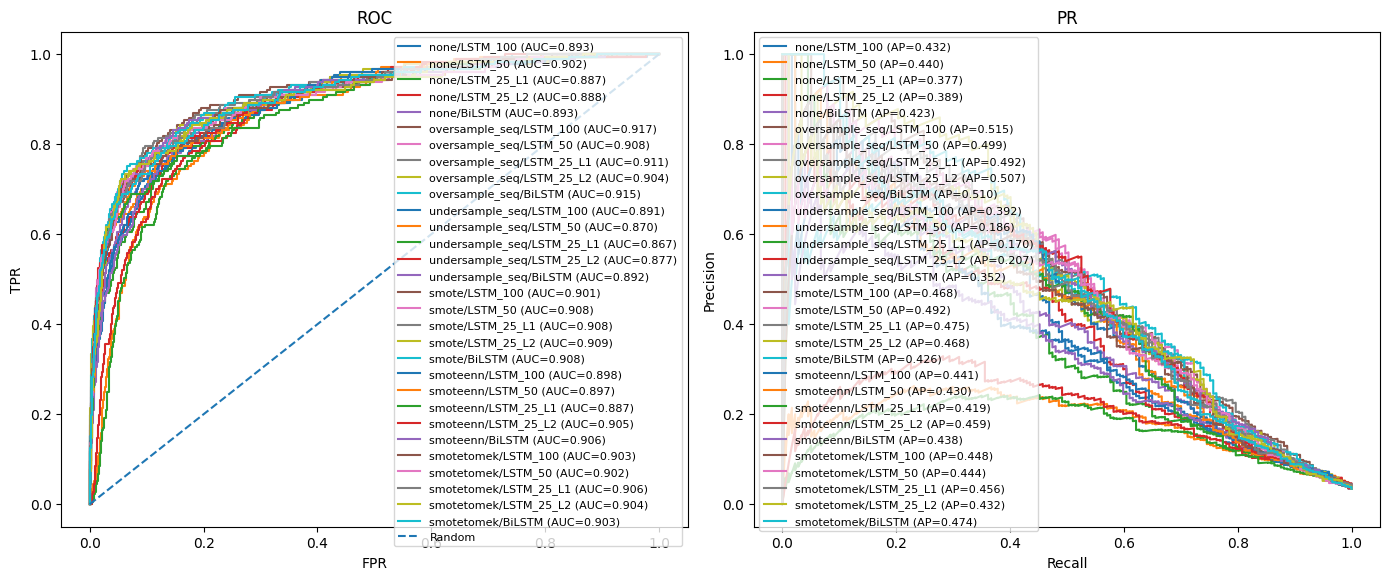


📁 Saved files:
 - plots/combined_roc_pr_curves.png
 - outputs/results_summary_all1.csv

Split counts:
Split
train           122
test            122
testBalanced    122
Name: count, dtype: int64

🔽 ORIGINAL TEST — top by Overall/F1_weighted
    Method       Model  Threshold  Overall/F1_weighted  \
13    none     LSTM_50       0.40               0.9653   
16    none     LSTM_50       0.41               0.9651   
43    none      BiLSTM       0.40               0.9646   
4     none    LSTM_100       0.41               0.9641   
1     none    LSTM_100       0.40               0.9640   
7     none    LSTM_100       0.50               0.9601   
19    none     LSTM_50       0.50               0.9599   
46    none      BiLSTM       0.50               0.9588   
25    none  LSTM_25_L1       0.40               0.9581   
211  smote  LSTM_25_L1       0.60               0.9572   

     Overall/Recall_weighted  Overall/Precision_weighted  Overall/ROC-AUC  \
13                    0.9701               

In [12]:
# ==============================================
# Leak-free Ramadan features + Balanced LSTM
# (NO visit/daily features; lifestyle PCs kept)
# ==============================================

# (Optional) pin versions in Kaggle/Colab:
!pip install --upgrade pip
!pip install numpy==1.26.4 scipy==1.13.0 scikit-learn==1.5.1 imbalanced-learn==0.13.0 tensorflow==2.18.0 joblib==1.4.2

import os
import time
import warnings
warnings.filterwarnings("ignore")

import random
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve,
    average_precision_score, auc, mean_squared_error
)

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import joblib

# --------------------
# GLOBAL CONFIG
# --------------------
CSV_INTRADAY_WITH_VISITS = "/kaggle/input/hmcdataset/intraday_with_visits.csv"
CSV_INTRADAY_BASIC       = "/kaggle/input/hmcdataset/intraday.csv"

OUT_HOURLY_CSV = "/kaggle/working/dynamic_hourly_features_ramadan.csv"

RAMADAN_START = pd.to_datetime("2023-03-22")
RAMADAN_END   = pd.to_datetime("2023-04-19")
HYPO_CUTOFF   = 70.0          # mg/dL
MIN_CGM_PER_H = 4
SEQ_LEN       = 36            # hours per sequence window

# Wearable columns you *might* have (safe-checked & hour-averaged)
LIFESTYLE_COLS_CANDIDATES = [
    "steps","distance","calories","heart_rate","spo2",
    "deep","light","rem","nap","awake"
]

# ==> FINAL feature set (no visit/daily broadcasts)
ALL_FEATURES = (
    "cgm_min","cgm_max","cgm_mean","cgm_std",
    "cgm_mean_plus_std","cgm_mean_minus_std",
    "pca_cgm1","pca_cgm2","pca_cgm3",
    "pc1_activity_energy","pc2_physiology","pc3_sleep_rest"
)

# Training config
RANDOM_STATE     = 42
THR_MIN, THR_MAX = 0.40, 0.60
AUGMENT_SIGMA    = 0.01  # small Gaussian jitter on train (optional); set None to disable
RESAMPLE_METHODS = [
    "none",           # baseline (class_weight + focal)
    "oversample_seq", # duplicate minority sequences
    "undersample_seq",# downsample majority sequences
    "smote",          # SMOTE on flattened sequences
    "smoteenn",       # SMOTE+ENN on flattened sequences
    "smotetomek"      # SMOTE+Tomek on flattened sequences
]

# --------------------
# General Utilities
# --------------------
def to_dt(x, utc_ok=True):
    return pd.to_datetime(x, errors="coerce", utc=utc_ok)

def ensure_numeric(df, exclude=("patientID","huaweiID","visit_assigned","period_main","start","date","hour","hour_of_day")):
    ex = set(exclude)
    for c in df.columns:
        if c not in ex:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def filter_ramadan(df):
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    return df[(df["date"] >= RAMADAN_START) & (df["date"] <= RAMADAN_END)].copy()

def set_global_seeds(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_global_seeds(RANDOM_STATE)

# ------------------------------------------------------
# Part A — Ramadan hourly features with leak-free PCA
# ------------------------------------------------------
def build_ramadan_hourly_features_leakfree(
    in_csv=CSV_INTRADAY_WITH_VISITS,
    out_csv=OUT_HOURLY_CSV,
    min_cgm_per_hour=MIN_CGM_PER_H,
    test_size=0.2,
    random_state=RANDOM_STATE,
    save_artifacts=True
):
    """
    Build Ramadan hourly features from *dynamic* signals only:
      - CGM stats/composites
      - CGM PCA (fit on train patients only)
      - Lifestyle PCA (fit on train patients only; optional if wearable cols exist)
    NO visit/daily broadcasts are used; NO static columns.

    Returns:
      hourly_out: combined DataFrame with engineered features (train+test concatenated)
      (train_pat, test_pat): patient ID arrays used for the split
    """
    if not os.path.exists(in_csv):
        raise FileNotFoundError(f"Input not found: {in_csv}")

    df = pd.read_csv(in_csv)

    # --- timestamps / numerics
    df["start"] = to_dt(df.get("start"))
    if "date" not in df.columns or df["date"].isna().all():
        df["date"] = pd.to_datetime(df["start"].dt.date)

    df["hour"] = df["start"].dt.floor("h")
    df["hour_of_day"] = df["hour"].dt.hour
    df = ensure_numeric(df)

    # --- Ramadan filter
    df = filter_ramadan(df)

    # --- require CGM
    if "cgm" not in df.columns:
        raise ValueError("❌ Dataset must include 'cgm' column.")
    df_cgm = df.dropna(subset=["cgm"]).copy()

    # --- only hours with enough CGM samples
    valid_hours = (
        df_cgm.groupby(["patientID","hour"])
              .filter(lambda g: g["cgm"].notna().sum() >= min_cgm_per_hour)
    )

    # --- base hourly CGM stats
    hourly = (
        valid_hours
        .groupby(["patientID","hour"], as_index=False)
        .agg(
            cgm_min=("cgm","min"),
            cgm_max=("cgm","max"),
            cgm_mean=("cgm","mean"),
            cgm_std=("cgm","std")
        )
        .sort_values(["patientID","hour"])
        .reset_index(drop=True)
    )
    hourly["hour_of_day"] = hourly["hour"].dt.hour

    # --- hypo label (any CGM < cutoff during the hour)
    lab = (
        valid_hours.groupby(["patientID","hour"])["cgm"]
        .apply(lambda x: int((x < HYPO_CUTOFF).any()))
        .reset_index(name="hypo_label")
    )
    hourly = hourly.merge(lab, on=["patientID","hour"], how="left")

    # --- composite CGM features
    hourly["cgm_mean_plus_std"]  = hourly["cgm_mean"] + hourly["cgm_std"]
    hourly["cgm_mean_minus_std"] = hourly["cgm_mean"] - hourly["cgm_std"]

    # --- optional lifestyle block (dynamic wearable signals) to be PCA'd later
    lifestyle_cols = [c for c in LIFESTYLE_COLS_CANDIDATES if c in df_cgm.columns]
    if lifestyle_cols:
        life_hourly = (
            df_cgm.groupby(["patientID","hour"], as_index=False)[lifestyle_cols]
                  .mean()
                  .fillna(0.0)
        )
        hourly = hourly.merge(life_hourly, on=["patientID","hour"], how="left").fillna(0.0)

    # Ensure PC columns exist (filled later / zeros if PCA not possible)
    for col in ["pc1_activity_energy","pc2_physiology","pc3_sleep_rest"]:
        if col not in hourly.columns:
            hourly[col] = 0.0

    # --- split patients BEFORE any PCA to avoid leakage
    unique_patients = hourly["patientID"].dropna().unique()
    train_pat, test_pat = train_test_split(unique_patients, test_size=test_size, random_state=random_state)
    train_df = hourly[hourly["patientID"].isin(train_pat)].copy()
    test_df  = hourly[hourly["patientID"].isin(test_pat)].copy()

    # --- CGM PCA on train only, transform both
    cgm_cols = ["cgm_min","cgm_max","cgm_mean","cgm_std"]
    scal_cgm = StandardScaler().fit(train_df[cgm_cols].fillna(0.0))
    pca_cgm  = PCA(n_components=3, random_state=random_state).fit(
        scal_cgm.transform(train_df[cgm_cols].fillna(0.0))
    )

    def _apply_cgm(df_in):
        X = scal_cgm.transform(df_in[cgm_cols].fillna(0.0))
        Z = pca_cgm.transform(X)
        out = df_in.copy()
        out["pca_cgm1"], out["pca_cgm2"], out["pca_cgm3"] = Z[:,0], Z[:,1], Z[:,2]
        return out

    train_df = _apply_cgm(train_df)
    test_df  = _apply_cgm(test_df)

    # --- lifestyle PCA (train-only fit), robust to <3 lifestyle features
    if lifestyle_cols:
        X_train_life = train_df[lifestyle_cols].fillna(0.0)
        # PCA requires n_components <= min(n_samples, n_features)
        n_comp_life = int(min(3, X_train_life.shape[1], max(1, X_train_life.shape[0])))
        if n_comp_life >= 1:
            scal_life = StandardScaler().fit(X_train_life)
            pca_life  = PCA(n_components=n_comp_life, random_state=random_state).fit(scal_life.transform(X_train_life))

            def _apply_life(df_in):
                out = df_in.copy()
                X = scal_life.transform(out[lifestyle_cols].fillna(0.0))
                Z = pca_life.transform(X)
                # write as many PCs as computed, fill the rest with zeros
                pc_names = ["pc1_activity_energy","pc2_physiology","pc3_sleep_rest"]
                for i in range(3):
                    if i < n_comp_life:
                        out[pc_names[i]] = Z[:, i]
                    else:
                        if pc_names[i] not in out.columns:
                            out[pc_names[i]] = 0.0
                return out

            train_df = _apply_life(train_df)
            test_df  = _apply_life(test_df)
        # else: leave the pre-created zero PC columns as-is

    # --- save & return (combined for convenience)
    hourly_out = pd.concat([train_df, test_df], axis=0).sort_values(["patientID","hour"]).reset_index(drop=True)
    hourly_out.to_csv(out_csv, index=False)
    print(f"✅ Saved leak‑free Ramadan hourly features to: {out_csv}")

    # Optionally save artifacts for reproducibility
    if save_artifacts:
        os.makedirs("/kaggle/working/artifacts", exist_ok=True)
        joblib.dump({"scal_cgm":scal_cgm, "pca_cgm":pca_cgm, "cols":cgm_cols},
                    "/kaggle/working/artifacts/cgm_pca.joblib")
        if lifestyle_cols and 'scal_life' in locals():
            joblib.dump({"scal_life":scal_life, "pca_life":pca_life, "cols":lifestyle_cols},
                        "/kaggle/working/artifacts/life_pca.joblib")

    return hourly_out, (train_pat, test_pat)

# ------------------------------------------------------
# Part B — LSTM sequences from HOURLY CSV (supports PCs)
# ------------------------------------------------------
def build_lstm_sequences_from_hourly(
    hourly_df_or_path=OUT_HOURLY_CSV,
    seq_len=SEQ_LEN,
    feature_cols=ALL_FEATURES,
    split_patients=None  # <-- (train_pat, test_pat)
):
    """
    Build sequences directly from the Ramadan hourly features CSV/DataFrame.
    Uses ONLY dynamic signals (no statics, no visit/daily).
    Pass split_patients from the leak-free PCA step to avoid leakage.
    """
    if isinstance(hourly_df_or_path, (str, Path)):
        if not os.path.exists(hourly_df_or_path):
            raise FileNotFoundError(f"Hourly features not found: {hourly_df_or_path}")
        hourly = pd.read_csv(hourly_df_or_path)
    else:
        hourly = hourly_df_or_path.copy()

    req = {"patientID","hour","hypo_label"}
    missing = req - set(hourly.columns)
    if missing:
        raise KeyError(f"Hourly features missing required columns: {missing}")

    hourly["hour"] = pd.to_datetime(hourly["hour"], errors="coerce")
    feature_cols = list(feature_cols)

    # Ensure all requested feature cols exist (some PCs might be zeros if PCA unavailable)
    soft_missing = [c for c in feature_cols if c not in hourly.columns]
    for c in soft_missing:
        hourly[c] = 0.0

    hourly = hourly.sort_values(["patientID","hour"]).reset_index(drop=True)

    if split_patients is None:
        raise ValueError("Pass split_patients=(train_pat, test_pat) from the leak‑free PCA step.")
    train_pat, test_pat = split_patients
    train_df = hourly[hourly["patientID"].isin(train_pat)].copy()
    test_df  = hourly[hourly["patientID"].isin(test_pat)].copy()

    def build_sequences(df_in, feature_cols, label_col="hypo_label", seq_len=SEQ_LEN):
        X, y = [], []
        for pid, grp in df_in.groupby("patientID"):
            grp = grp.sort_values("hour").reset_index(drop=True)
            for i in range(len(grp) - seq_len):
                X.append(grp.loc[i:i+seq_len-1, feature_cols].values)
                y.append(int(grp.loc[i+seq_len, label_col]))
        return np.array(X), np.array(y)

    X_train, y_train = build_sequences(train_df, feature_cols, seq_len=seq_len)
    X_test,  y_test  = build_sequences(test_df,  feature_cols, seq_len=seq_len)

    print(f"✅ Sequences (Hourly/ALL_FEATURES, leak‑free) — train: {X_train.shape}, test: {X_test.shape} | features={feature_cols}")
    return (X_train, y_train, X_test, y_test), (train_df, test_df)

# ------------------------------------------------------
# Balanced LSTM pipeline utilities (metrics, resampling)
# ------------------------------------------------------
def _best_threshold_in_range(thresholds, scores, thr_min=THR_MIN, thr_max=THR_MAX):
    thresholds = np.asarray(thresholds, dtype=float)
    scores     = np.asarray(scores, dtype=float)
    mask = np.isfinite(thresholds) & (thresholds >= thr_min) & (thresholds <= thr_max)
    if mask.any():
        idx_in = int(np.nanargmax(scores[mask]))
        idx    = np.where(mask)[0][idx_in]
        return float(thresholds[idx]), True
    idx = int(np.nanargmax(scores))
    return float(np.clip(thresholds[idx], thr_min, thr_max)), False

def focal_loss(gamma=2.0, alpha=0.25):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
    eps = tf.keras.backend.epsilon()
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        ce = bce(y_true, y_pred)
        p_t = y_true * y_pred + (1.0 - y_true) * (1.0 - y_pred)
        alpha_t = y_true * alpha + (1.0 - y_true) * (1.0 - alpha)
        modulating = tf.pow(1.0 - p_t, gamma)
        return alpha_t * modulating * ce
    return loss

def _safe_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    if cm.shape != (2,2):
        full = np.zeros((2,2), dtype=int)
        full[:cm.shape[0], :cm.shape[1]] = cm
        cm = full
    return cm

def _specificity_overall(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return tn / (tn + fp + 1e-8)

def _specificity_per_class(y_true, y_pred, positive_label):
    # TNR for the "not positive_label" class, computed by binarizing on that label
    y_true_bin = (np.asarray(y_true).ravel() == positive_label).astype(int)
    y_pred_bin = (np.asarray(y_pred).ravel() == positive_label).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1]).ravel()
    return tn / (tn + fp + 1e-8)

def evaluate_full_metrics(y_true, y_pred, y_prob=None):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_pred = np.asarray(y_pred).astype(int).ravel()
    cm = _safe_confusion_matrix(y_true, y_pred)

    metrics = {}
    for lbl in [0,1]:
        metrics[f"Class{lbl}/Precision"]   = precision_score(y_true, y_pred, pos_label=lbl, zero_division=0)
        metrics[f"Class{lbl}/Recall"]      = recall_score(y_true, y_pred,    pos_label=lbl, zero_division=0)
        metrics[f"Class{lbl}/F1"]          = f1_score(y_true, y_pred,        pos_label=lbl, zero_division=0)
        metrics[f"Class{lbl}/Specificity"] = _specificity_per_class(y_true, y_pred, positive_label=lbl)
        metrics[f"Class{lbl}/Support"]     = int(np.sum(y_true == lbl))

    # overall (hard preds)
    metrics["Overall/Accuracy"]             = accuracy_score(y_true, y_pred)
    metrics["Overall/Precision_macro"]      = precision_score(y_true, y_pred, average='macro',    zero_division=0)
    metrics["Overall/Precision_weighted"]   = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics["Overall/Recall_macro"]         = recall_score(y_true, y_pred,    average='macro',    zero_division=0)
    metrics["Overall/Recall_weighted"]      = recall_score(y_true, y_pred,    average='weighted', zero_division=0)
    metrics["Overall/F1_macro"]             = f1_score(y_true, y_pred,        average='macro',    zero_division=0)
    metrics["Overall/F1_weighted"]          = f1_score(y_true, y_pred,        average='weighted', zero_division=0)
    metrics["Overall/Specificity"]          = _specificity_overall(y_true, y_pred)
    mse_pred                                = mean_squared_error(y_true, y_pred)
    metrics["Overall/RMSE_pred"]            = float(np.sqrt(mse_pred))

    # prob-based
    if y_prob is not None:
        y_prob = np.asarray(y_prob, dtype=float).ravel()
        try:  metrics["Overall/ROC-AUC"] = roc_auc_score(y_true, y_prob)
        except ValueError: metrics["Overall/ROC-AUC"] = np.nan
        try:  metrics["Overall/PR-AUC"]  = average_precision_score(y_true, y_prob)
        except ValueError: metrics["Overall/PR-AUC"] = np.nan
        mse_prob                          = mean_squared_error(y_true, y_prob)
        metrics["Overall/RMSE_prob"]      = float(np.sqrt(mse_prob))
    else:
        metrics["Overall/ROC-AUC"]  = np.nan
        metrics["Overall/PR-AUC"]   = np.nan
        metrics["Overall/RMSE_prob"]= np.nan

    return metrics

def make_class_weight(y):
    y  = np.asarray(y).astype(int).ravel()
    n0 = max(1, (y==0).sum()); n1 = max(1, (y==1).sum()); N = n0+n1
    w0 = N/(2.0*n0); w1 = N/(2.0*n1)
    return {0: float(w0), 1: float(w1)}

def augment(X, y, sigma=AUGMENT_SIGMA):
    if sigma is None or sigma <= 0: 
        return X, y
    noise = np.random.normal(0, sigma, X.shape)
    return np.vstack([X, X+noise]), np.hstack([y, y])

def seq_resample(X, y, method="none", random_state=RANDOM_STATE):
    """
    Sequence-level resampling.
    method ∈ {"none","oversample_seq","undersample_seq","smote","smoteenn","smotetomek"}
    """
    X = np.asarray(X); y = np.asarray(y).astype(int).ravel()
    n, T, F = X.shape

    if method == "none":
        return X, y

    if method in {"oversample_seq","undersample_seq"}:
        rng = np.random.default_rng(random_state)
        idx0 = np.where(y==0)[0]; idx1 = np.where(y==1)[0]
        n0, n1 = len(idx0), len(idx1)
        if n0==0 or n1==0:
            return X, y

        if method == "oversample_seq":
            if n1 < n0:
                add = rng.choice(idx1, size=n0-n1, replace=True)
                keep = np.concatenate([idx0, idx1, add])
            else:
                add = rng.choice(idx0, size=n1-n0, replace=True)
                keep = np.concatenate([idx0, idx1, add])
        else:
            if n0 > n1:
                keep0 = rng.choice(idx0, size=n1, replace=False)
                keep  = np.concatenate([keep0, idx1])
            else:
                keep1 = rng.choice(idx1, size=n0, replace=False)
                keep  = np.concatenate([idx0, keep1])

        rng.shuffle(keep)
        return X[keep], y[keep]

    # SMOTE family on flattened sequences with guard
    Xf = X.reshape(n, -1)
    minority_n = int((y==1).sum())
    majority_n = int((y==0).sum())
    if minority_n < 2 or majority_n < 2:
        print("⚠️ Not enough samples for SMOTE/SMOTEENN/SMOTETomek; skipping resampling.")
        return X, y

    if method == "smote":
        k_neighbors = max(1, min(5, minority_n-1))
        sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        Xr, yr = sm.fit_resample(Xf, y)
    elif method == "smoteenn":
        Xr, yr = SMOTEENN(random_state=random_state).fit_resample(Xf, y)
    elif method == "smotetomek":
        Xr, yr = SMOTETomek(random_state=random_state).fit_resample(Xf, y)
    else:
        raise ValueError(f"Unknown resampling method: {method}")
    return Xr.reshape(-1, T, F), yr

def make_balanced_test(X_test, y_test, random_state=RANDOM_STATE):
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test).astype(int).ravel()
    idx0, idx1 = np.where(y_test==0)[0], np.where(y_test==1)[0]
    if len(idx0)==0 or len(idx1)==0: return X_test, y_test
    m = min(len(idx0), len(idx1))
    rs = np.random.RandomState(random_state)
    keep = np.concatenate([rs.choice(idx0, m, replace=False), rs.choice(idx1, m, replace=False)])
    rs.shuffle(keep)
    return X_test[keep], y_test[keep]

def define_models(input_shape):
    return {
        "LSTM_100": Sequential([
            Input(shape=input_shape),
            LSTM(100, return_sequences=True), Dropout(0.2),
            LSTM(50), Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_50": Sequential([
            Input(shape=input_shape),
            LSTM(50, return_sequences=True), Dropout(0.2),
            LSTM(25), Dropout(0.2),
            Dense(10, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_25_L1": Sequential([
            Input(shape=input_shape),
            LSTM(50, return_sequences=True, kernel_regularizer=l1(1e-5)), Dropout(0.2),
            LSTM(25, kernel_regularizer=l1(1e-5)), Dropout(0.2),
            Dense(10, activation='relu', kernel_regularizer=l1(1e-5)),
            Dense(1, activation='sigmoid')
        ]),
        "LSTM_25_L2": Sequential([
            Input(shape=input_shape),
            LSTM(50, return_sequences=True, kernel_regularizer=l2(1e-5)), Dropout(0.2),
            LSTM(25, kernel_regularizer=l2(1e-5)), Dropout(0.2),
            Dense(10, activation='relu', kernel_regularizer=l2(1e-5)),
            Dense(1, activation='sigmoid')
        ]),
        "BiLSTM": Sequential([
            Input(shape=input_shape),
            Bidirectional(LSTM(64, return_sequences=True)), Dropout(0.2),
            Bidirectional(LSTM(32)), Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
    }

def run_balanced_lstm_pipeline(X_train, y_train, X_test, y_test,
                               resample_methods=RESAMPLE_METHODS,
                               thr_min=THR_MIN, thr_max=THR_MAX,
                               random_state=RANDOM_STATE):
    """
    Trains all models across resampling methods, writes plots + CSV summary,
    and returns the results DataFrame.
    """
    os.makedirs("checkpoints", exist_ok=True)
    os.makedirs("plots", exist_ok=True)
    os.makedirs("outputs", exist_ok=True)

    # tiny augmentation (optional)
    X_train_aug, y_train_aug = augment(X_train, y_train, sigma=AUGMENT_SIGMA)

    # balanced test copy (for fair diagnostic read)
    X_test_bal, y_test_bal = make_balanced_test(X_test, y_test)

    results = {}       # key -> metrics dict
    roc_data = {}      # (method, model) -> (fpr, tpr, auc)
    pr_data  = {}      # (method, model) -> (recall, precision, ap)
    best_thresholds = {}  # (method, model) -> {"youden": t, "f1": t}

    def train_eval_one(method_name, model_name, model, Xtr, ytr, Xte, yte, XteB, yteB):
        tag = f"{method_name}__{model_name}"
        print(f"\n🚀 Training [{tag}] with class-weighted focal loss")
        es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
        cp = ModelCheckpoint(f"checkpoints/{tag}.h5", save_best_only=True, monitor='val_loss', verbose=0)
        model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

        class_weight = make_class_weight(ytr)
        t0 = time.time()
        model.fit(Xtr, ytr, epochs=5, batch_size=32,
                  validation_data=(Xte, yte),
                  callbacks=[es, cp], verbose=1,
                  class_weight=class_weight)
        print(f"⏱️ Training Time: {time.time()-t0:.2f}s")

        # probabilities
        p_tr  = model.predict(Xtr,  verbose=0).ravel()
        p_te  = model.predict(Xte,  verbose=0).ravel()
        p_teB = model.predict(XteB, verbose=0).ravel()

        # thresholds (on ORIGINAL test), constrained to [thr_min, thr_max]
        try:
            fpr, tpr, thr_roc = roc_curve(yte, p_te); auc_roc = auc(fpr, tpr)
        except ValueError:
            fpr, tpr, thr_roc, auc_roc = np.array([0,1]), np.array([0,1]), np.array([0.5]), np.nan
        youden = tpr - fpr
        t_roc, _ = _best_threshold_in_range(thr_roc, youden, thr_min, thr_max)

        prec, rec, thr_pr = precision_recall_curve(yte, p_te)
        f1s = 2*prec[:-1]*rec[:-1] / (prec[:-1]+rec[:-1]+1e-8)
        t_pr, _ = _best_threshold_in_range(thr_pr, f1s, thr_min, thr_max)
        ap_val  = average_precision_score(yte, p_te)

        roc_data[(method_name, model_name)] = (fpr, tpr, auc_roc)
        pr_data[(method_name, model_name)]  = (rec, prec, ap_val)
        best_thresholds[(method_name, model_name)] = {"youden": t_roc, "f1": t_pr}
        print(f"📌 [{tag}] thresholds → Youden={t_roc:.4f}, PR-F1={t_pr:.4f} (window [{thr_min},{thr_max}])")

        eval_ts = sorted(set([thr_min, 0.50, thr_max, float(t_roc), float(t_pr)]))
        # evaluate at all thresholds on train / test / testBalanced
        for t in eval_ts:
            yhat_tr  = (p_tr  >= t).astype(int)
            yhat_te  = (p_te  >= t).astype(int)
            yhat_teB = (p_teB >= t).astype(int)

            results[f"{tag}__thr_{t:.2f}__train"]         = evaluate_full_metrics(ytr,  yhat_tr,  p_tr)
            results[f"{tag}__thr_{t:.2f}__test"]          = evaluate_full_metrics(yte,  yhat_te,  p_te)
            results[f"{tag}__thr_{t:.2f}__testBalanced"]  = evaluate_full_metrics(yteB, yhat_teB, p_teB)

    # run all methods x models
    input_shape = (X_train_aug.shape[1], X_train_aug.shape[2])
    for METHOD in resample_methods:
        Xtr_rs, ytr_rs = seq_resample(X_train_aug, y_train_aug, method=METHOD, random_state=random_state)
        print(f"\n🔁 Resampling: {METHOD} → X={Xtr_rs.shape}, y={Counter(ytr_rs)}")
        for mname, model in define_models(input_shape).items():
            train_eval_one(METHOD, mname, model, Xtr_rs, ytr_rs, X_test, y_test, X_test_bal, y_test_bal)

    # --------------------------
    # Curves (optional plots)
    # --------------------------
    plt.figure(figsize=(14,6))
    # ROC
    plt.subplot(1,2,1)
    for (meth, mname), (fpr, tpr, auc_roc) in roc_data.items():
        plt.plot(fpr, tpr, label=f'{meth}/{mname} (AUC={auc_roc:.3f})')
    plt.plot([0,1],[0,1],'--',label='Random')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.legend(fontsize=8)
    # PR
    plt.subplot(1,2,2)
    for (meth, mname), (rec, prec, ap) in pr_data.items():
        plt.plot(rec, prec, label=f'{meth}/{mname} (AP={ap:.3f})')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR'); plt.legend(fontsize=8)
    plt.tight_layout(); plt.savefig("plots/combined_roc_pr_curves.png", dpi=300); plt.show()

    # --------------------------
    # Summaries
    # --------------------------
    results_df = pd.DataFrame(results).T
    results_df = results_df.reset_index().rename(columns={"index":"Key"})

    # Split extraction
    k = results_df["Key"].str.strip()
    split = np.where(k.str.endswith("__train"), "train",
             np.where(k.str.endswith("__testBalanced"), "testBalanced",
             np.where(k.str.endswith("__test"), "test", np.nan)))
    results_df["Split"] = split

    # Method, Model, Threshold extraction
    parts = k.str.split("__")
    results_df["Method"] = parts.str[0]
    results_df["Model"]  = parts.str[1]
    thr_str = parts.str[2].str.replace("thr_","", regex=False)
    with np.errstate(all='ignore'):
        results_df["Threshold"] = pd.to_numeric(thr_str, errors="coerce")

    # Save
    results_df.round(6).to_csv("outputs/results_summary_all1.csv", index=False)
    print("\n📁 Saved files:")
    print(" - plots/combined_roc_pr_curves.png")
    print(" - outputs/results_summary_all1.csv")

    # Quick sanity
    print("\nSplit counts:")
    print(results_df["Split"].value_counts(dropna=False))

    # Leaderboards
    eval_test_df  = results_df[results_df["Split"]=="test"].copy()
    eval_tbal_df  = results_df[results_df["Split"]=="testBalanced"].copy()

    def top_k(df, by_col, k=10, cols=None):
        if df.empty:
            return pd.DataFrame(columns=(cols or []))
        if cols is None:
            cols = ['Method','Model','Threshold','Overall/F1_weighted','Overall/Recall_weighted',
                    'Overall/Precision_weighted','Overall/ROC-AUC','Overall/PR-AUC','Overall/Accuracy']
        present = [c for c in cols if c in df.columns]
        return df.sort_values(by_col, ascending=False)[present].head(k).round(4)

    print("\n🔽 ORIGINAL TEST — top by Overall/F1_weighted")
    print(top_k(eval_test_df, 'Overall/F1_weighted'))

    print("\n🔽 BALANCED TEST — top by Overall/F1_weighted")
    print(top_k(eval_tbal_df, 'Overall/F1_weighted'))

    def best_per_model(df):
        if df.empty:
            return df
        idx = df.groupby(['Method','Model'])['Overall/F1_weighted'].idxmax()
        return df.loc[idx].sort_values(['Overall/F1_weighted'], ascending=False)

    overall_cols = [
        'Overall/Accuracy','Overall/Precision_macro','Overall/Recall_macro','Overall/F1_macro',
        'Overall/Precision_weighted','Overall/Recall_weighted','Overall/F1_weighted',
        'Overall/Specificity','Overall/ROC-AUC','Overall/PR-AUC',
        'Overall/RMSE_pred','Overall/RMSE_prob'
    ]
    class_cols = [
        'Class0/Precision','Class0/Recall','Class0/F1','Class0/Specificity','Class0/Support',
        'Class1/Precision','Class1/Recall','Class1/F1','Class1/Specificity','Class1/Support'
    ]

    print("\n=== ORIGINAL TEST — best per (Method,Model) ===")
    best_test = best_per_model(eval_test_df)
    if best_test.empty:
        print("⚠️ No TEST rows found — check Split counts above.")
    else:
        print(best_test[['Method','Model','Threshold']+[c for c in overall_cols if c in best_test.columns]].round(4))
        print("\n--- Per-class breakdown:")
        print(best_test[['Method','Model','Threshold']+[c for c in class_cols if c in best_test.columns]].round(4))

    print("\n=== BALANCED TEST — best per (Method,Model) ===")
    best_tbal = best_per_model(eval_tbal_df)
    if best_tbal.empty:
        print("⚠️ No BALANCED TEST rows found — check Split counts above.")
    else:
        print(best_tbal[['Method','Model','Threshold']+[c for c in overall_cols if c in best_tbal.columns]].round(4))
        print("\n--- Per-class breakdown:")
        print(best_tbal[['Method','Model','Threshold']+[c for c in class_cols if c in best_tbal.columns]].round(4))

    return results_df

# ------------------------------------------------------
# CGM-only (raw intraday) sequence builder
# ------------------------------------------------------
def build_cgm_only_sequences_from_intraday(
    in_csv=CSV_INTRADAY_BASIC,
    seq_len=SEQ_LEN,
    label_cutoff=HYPO_CUTOFF,
    min_cgm_per_hour=MIN_CGM_PER_H,
    feature_cols=("cgm_mean",),  # customize: ("cgm_mean","cgm_std","cgm_min","cgm_max")
    test_size=0.3,
    random_state=RANDOM_STATE
):
    """
    Build CGM-only hourly features from intraday and convert to sequences.
    Splits by patient to avoid leakage.
    """
    if not os.path.exists(in_csv):
        raise FileNotFoundError(f"Input not found: {in_csv}")

    df = pd.read_csv(in_csv)
    df["start"] = to_dt(df.get("start"))
    df["hour"]  = df["start"].dt.floor("h")

    base = df[["patientID","hour","cgm"]].dropna(subset=["cgm"])
    valid = base.groupby(["patientID","hour"]).filter(lambda g: g["cgm"].notna().sum() >= min_cgm_per_hour)

    feats = (
        valid.groupby(["patientID","hour"])
             .agg(
                 cgm_std=("cgm","std"),
                 cgm_min=("cgm","min"),
                 cgm_mean=("cgm","mean"),
                 cgm_max=("cgm","max"),
                 hypo_label=("cgm", lambda x: int((x < label_cutoff).any()))
             )
             .reset_index()
             .sort_values(["patientID","hour"])
             .reset_index(drop=True)
    )

    # leakage-proof split
    unique_patients = feats["patientID"].unique()
    train_pat, test_pat = train_test_split(unique_patients, test_size=test_size, random_state=random_state)
    train_df = feats[feats["patientID"].isin(train_pat)].copy()
    test_df  = feats[feats["patientID"].isin(test_pat)].copy()

    feature_cols = list(feature_cols)
    for col in feature_cols + ["hypo_label"]:
        if col not in feats.columns:
            raise KeyError(f"Column '{col}' not found. Available: {feats.columns.tolist()}")

    def build_sequences(df_in, feature_cols, label_col="hypo_label", seq_len=seq_len):
        X, y = [], []
        for pid, grp in df_in.groupby("patientID"):
            grp = grp.sort_values("hour").reset_index(drop=True)
            for i in range(len(grp) - seq_len):
                X.append(grp.loc[i:i+seq_len-1, feature_cols].values)
                y.append(int(grp.loc[i+seq_len, label_col]))
        return np.array(X), np.array(y)

    X_train, y_train = build_sequences(train_df, feature_cols)
    X_test,  y_test  = build_sequences(test_df,  feature_cols)

    print(f"✅ Sequences (CGM-only) — train: {X_train.shape}, test: {X_test.shape} | features={feature_cols}")
    return (X_train, y_train, X_test, y_test), (train_df, test_df)

# ------------------------------------------------------
# Main control flags
# ------------------------------------------------------
RUN_FEATURE_BUILD          = False  # Build Ramadan hourly features + leak-free PCA
RUN_TRAINING_FROM_HOURLY   = True   # Train models using sequences built from hourly features
RUN_TRAINING_FROM_CGM_ONLY = False  # Train models using CGM-only sequences from raw intraday

# ------------------------------------------------------
# Orchestrate
# ------------------------------------------------------
if __name__ == "__main__":
    hourly_features = None
    split_pat       = None

    # Part A: Ramadan hourly features with leak-free PCA
    if RUN_FEATURE_BUILD or RUN_TRAINING_FROM_HOURLY:
        try:
            hourly_features, split_pat = build_ramadan_hourly_features_leakfree(
                in_csv=CSV_INTRADAY_WITH_VISITS,
                out_csv=OUT_HOURLY_CSV,
                min_cgm_per_hour=MIN_CGM_PER_H,
                test_size=0.3,
                random_state=RANDOM_STATE
            )
        except Exception as e:
            print(f"[WARN] Skipping Ramadan feature build: {e}")

    # Part B — Train from HOURLY sequences with ALL_FEATURES
    if RUN_TRAINING_FROM_HOURLY:
        try:
            if split_pat is None:
                raise RuntimeError("No patient split found. Ensure feature build step ran successfully.")
            (X_train, y_train, X_test, y_test), _ = build_lstm_sequences_from_hourly(
                hourly_df_or_path=OUT_HOURLY_CSV,
                seq_len=SEQ_LEN,
                feature_cols=ALL_FEATURES,
                split_patients=split_pat
            )
            _ = run_balanced_lstm_pipeline(X_train, y_train, X_test, y_test)
        except Exception as e:
            print(f"[WARN] Skipping hourly-based training: {e}")

    # Part B option 2 — Train from CGM-only (raw intraday) sequences
    if RUN_TRAINING_FROM_CGM_ONLY:
        try:
            (X_train_cgm, y_train_cgm, X_test_cgm, y_test_cgm), _ = build_cgm_only_sequences_from_intraday(
                in_csv=CSV_INTRADAY_BASIC,
                seq_len=SEQ_LEN,
                label_cutoff=HYPO_CUTOFF,
                min_cgm_per_hour=MIN_CGM_PER_H,
                feature_cols=("cgm_mean",)  # or: ("cgm_mean","cgm_std","cgm_min","cgm_max")
            )
            _ = run_balanced_lstm_pipeline(X_train_cgm, y_train_cgm, X_test_cgm, y_test_cgm)
        except Exception as e:
            print(f"[WARN] Skipping CGM-only training: {e}")


✅ Saved leak‑free Ramadan hourly features to: /kaggle/working/dynamic_hourly_features_ramadan.csv
✅ Sequences (Hourly/ALL_FEATURES, leak‑free) — train: (13351, 36, 12), test: (5148, 36, 12) | features=['cgm_min', 'cgm_max', 'cgm_mean', 'cgm_std', 'cgm_mean_plus_std', 'cgm_mean_minus_std', 'pca_cgm1', 'pca_cgm2', 'pca_cgm3', 'pc1_activity_energy', 'pc2_physiology', 'pc3_sleep_rest']


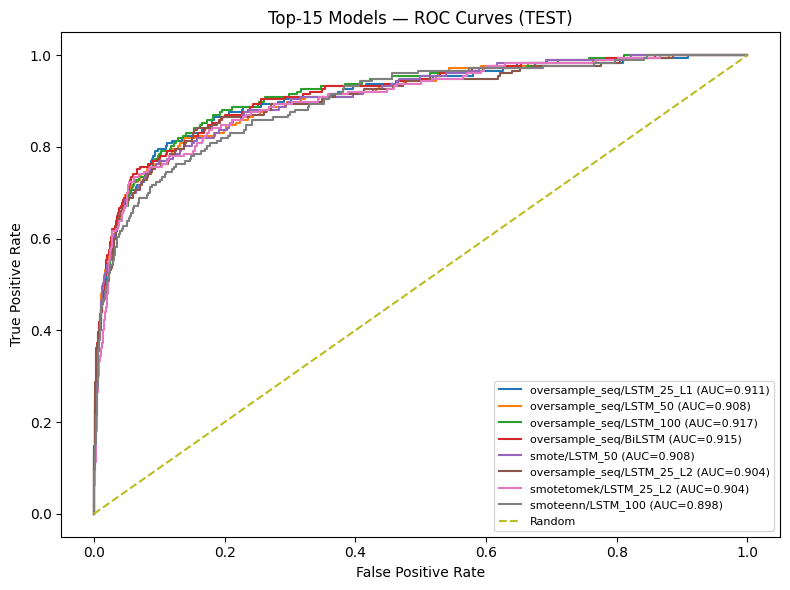

🖼️ Saved ROC plot: plots/top15_roc.png  (curves drawn for 8 configs)


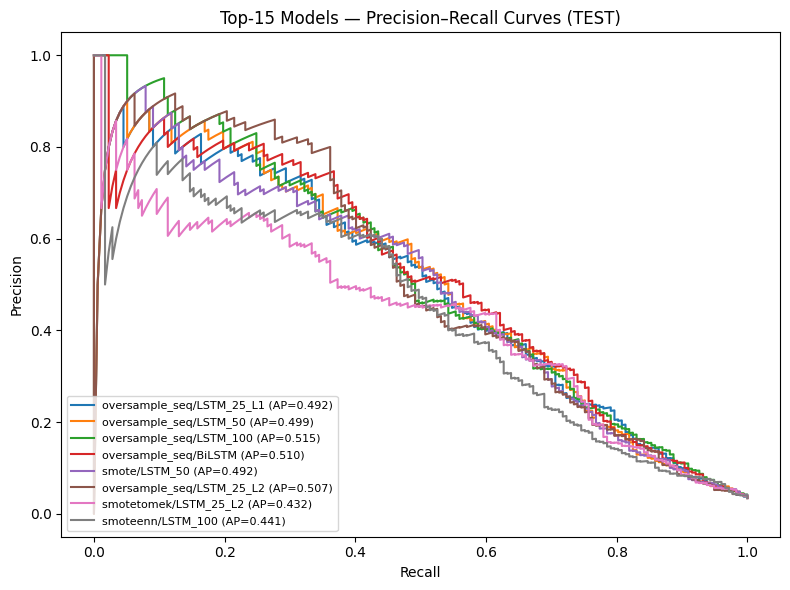

🖼️ Saved PR plot: plots/top15_pr.png  (curves drawn for 8 configs)


<Figure size 550x500 with 0 Axes>

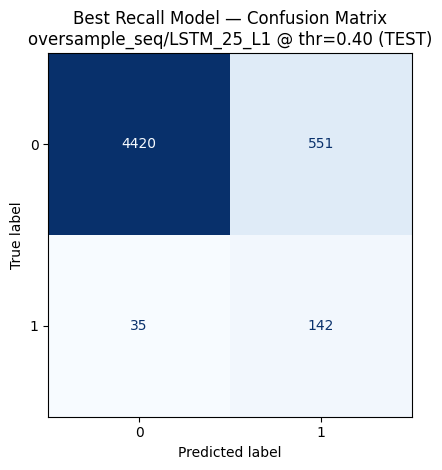

🖼️ Saved confusion matrix: plots/best_confusion.png
[Best Recall] oversample_seq/LSTM_25_L1 @ t=0.40 → TP=142, FP=551, TN=4420, FN=35


In [13]:
# ============================================================
# Post-run analysis: Top-15 ROC/PR curves + Best-model Confusion Matrix
# (Run this AFTER your previous training script finished)
# ============================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# ---- Config (must match your training run) ----
RANDOM_STATE = 42
SEQ_LEN      = 36
OUT_HOURLY_CSV = "/kaggle/working/dynamic_hourly_features_ramadan.csv"
CSV_INTRADAY_WITH_VISITS = "/kaggle/input/hmcdataset/intraday_with_visits.csv"

# Feature set used in the training code
ALL_FEATURES = (
    "cgm_min","cgm_max","cgm_mean","cgm_std",
    "cgm_mean_plus_std","cgm_mean_minus_std",
    "pca_cgm1","pca_cgm2","pca_cgm3",
    "pc1_activity_energy","pc2_physiology","pc3_sleep_rest"
)

RESULTS_CSV = "outputs/results_summary_all1.csv"
CKPT_FMT    = "checkpoints/{method}__{model}.h5"
PLOT_ROC    = "plots/top15_roc.png"
PLOT_PR     = "plots/top15_pr.png"
PLOT_CM     = "plots/best_confusion.png"

# ---- 0) Recreate the same test split + sequences (deterministic) ----
# Uses your previously defined functions. If they live in another module, import them instead.
hourly_features, split_pat = build_ramadan_hourly_features_leakfree(
    in_csv=CSV_INTRADAY_WITH_VISITS,
    out_csv=OUT_HOURLY_CSV,
    min_cgm_per_hour=4,
    test_size=0.3,
    random_state=RANDOM_STATE,
    save_artifacts=False
)

(X_train, y_train, X_test, y_test), _ = build_lstm_sequences_from_hourly(
    hourly_df_or_path=OUT_HOURLY_CSV,
    seq_len=SEQ_LEN,
    feature_cols=ALL_FEATURES,
    split_patients=split_pat
)

input_shape = (X_test.shape[1], X_test.shape[2])

# ---- 1) Load and rank results (TEST split) ----
if not os.path.exists(RESULTS_CSV):
    raise FileNotFoundError(f"Results CSV not found: {RESULTS_CSV}. Run the training pipeline first.")

df = pd.read_csv(RESULTS_CSV)
eval_test = df[df["Split"]=="test"].copy()
if eval_test.empty:
    raise RuntimeError("No TEST rows in results CSV. Re-run training or check the saved splits.")

# Add Brier from probability MSE if present; else fallback to NaN
if "Overall/MSE_prob" in eval_test.columns:
    eval_test["Brier"] = eval_test["Overall/MSE_prob"]
elif "Brier" not in eval_test.columns:
    eval_test["Brier"] = np.nan

# Ranking: Class1/Recall DESC, then F1_weighted DESC, PR-AUC DESC, Brier ASC
rank_cols = ["Class1/Recall", "Overall/F1_weighted", "Overall/PR-AUC", "Brier"]
for c in rank_cols:
    if c not in eval_test.columns:
        eval_test[c] = np.nan

ranked = eval_test.sort_values(
    by=["Class1/Recall","Overall/F1_weighted","Overall/PR-AUC","Brier"],
    ascending=[False, True if "Brier" in ["Class1/Recall","Overall/F1_weighted","Overall/PR-AUC"] else False, False, True]
)

# Note: the mixed ascending list above is tricky; explicitly set as below:
ranked = eval_test.sort_values(
    by=["Class1/Recall","Overall/F1_weighted","Overall/PR-AUC","Brier"],
    ascending=[False, False, False, True]
)

top15 = ranked.head(15).copy()
if top15.empty:
    raise RuntimeError("Top-15 selection is empty. Check your results CSV contents.")

# Extract method/model/threshold for each of the top 15
top15_info = top15[["Method","Model","Threshold"]].reset_index(drop=True)

# ---- 2) For each of these top 15, rebuild model, load weights, predict on test ----
# We reuse your define_models() helper to ensure identical architectures.
models = define_models(input_shape)

roc_curves = {}   # tag -> (fpr, tpr, auc)
pr_curves  = {}   # tag -> (rec, prec, ap)
probs_map  = {}   # tag -> predicted probabilities on test

for i, row in top15_info.iterrows():
    method = str(row["Method"])
    model_name = str(row["Model"])
    tag = f"{method}/{model_name}"

    ckpt_path = CKPT_FMT.format(method=method, model=model_name)
    if not os.path.exists(ckpt_path):
        print(f"⚠️ Missing checkpoint for {tag}: {ckpt_path}. Skipping.")
        continue

    # Build the same architecture and load weights
    if model_name not in models:
        print(f"⚠️ Unknown model arch in results: {model_name}. Skipping.")
        continue
    m = define_models(input_shape)[model_name]
    m.load_weights(ckpt_path)

    # Predict on ORIGINAL TEST
    p_test = m.predict(X_test, verbose=0).ravel()
    probs_map[tag] = p_test

    # ROC
    try:
        fpr, tpr, thr = roc_curve(y_test, p_test)
        auc_roc = auc(fpr, tpr)
    except ValueError:
        fpr, tpr, auc_roc = np.array([0,1]), np.array([0,1]), np.nan
    roc_curves[tag] = (fpr, tpr, auc_roc)

    # PR
    prec, rec, thr_pr = precision_recall_curve(y_test, p_test)
    ap = average_precision_score(y_test, p_test) if np.isfinite(p_test).all() else np.nan
    pr_curves[tag] = (rec, prec, ap)

# ---- 3) Plot ROC-AUC and PR-AUC for Top 15 ----
os.makedirs("plots", exist_ok=True)

# ROC
plt.figure(figsize=(8,6))
plotted = 0
for tag, (fpr, tpr, auc_roc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{tag} (AUC={auc_roc:.3f})")
    plotted += 1
plt.plot([0,1],[0,1],'--',label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Top-15 Models — ROC Curves (TEST)")
plt.legend(fontsize=8, loc="lower right", ncol=1)
plt.tight_layout()
plt.savefig(PLOT_ROC, dpi=300)
plt.show()
print(f"🖼️ Saved ROC plot: {PLOT_ROC}  (curves drawn for {plotted} configs)")

# PR
plt.figure(figsize=(8,6))
plotted = 0
for tag, (rec, prec, ap) in pr_curves.items():
    plt.plot(rec, prec, label=f"{tag} (AP={ap:.3f})")
    plotted += 1
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Top-15 Models — Precision–Recall Curves (TEST)")
plt.legend(fontsize=8, loc="lower left", ncol=1)
plt.tight_layout()
plt.savefig(PLOT_PR, dpi=300)
plt.show()
print(f"🖼️ Saved PR plot: {PLOT_PR}  (curves drawn for {plotted} configs)")

# ---- 4) Confusion matrix for the SINGLE best-recall model at its saved threshold ----
best_row = top15.iloc[0]
best_method = str(best_row["Method"])
best_model  = str(best_row["Model"])
best_thr    = float(best_row["Threshold"])
best_tag    = f"{best_method}/{best_model}"

if best_tag not in probs_map:
    # try to load it now if it was skipped earlier
    ckpt_path = CKPT_FMT.format(method=best_method, model=best_model)
    if os.path.exists(ckpt_path):
        m = define_models(input_shape)[best_model]
        m.load_weights(ckpt_path)
        probs_map[best_tag] = m.predict(X_test, verbose=0).ravel()
    else:
        raise FileNotFoundError(f"Checkpoint for best model not found: {ckpt_path}")

yhat_best = (probs_map[best_tag] >= best_thr).astype(int)
cm = confusion_matrix(y_test, yhat_best, labels=[0,1])

plt.figure(figsize=(5.5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(values_format='d', cmap='Blues', colorbar=False)
plt.title(f"Best Recall Model — Confusion Matrix\n{best_tag} @ thr={best_thr:.2f} (TEST)")
plt.tight_layout()
plt.savefig(PLOT_CM, dpi=300)
plt.show()
print(f"🖼️ Saved confusion matrix: {PLOT_CM}")

# Also print the key line so you can drop it in the paper/table
tn, fp, fn, tp = cm.ravel()
print(f"[Best Recall] {best_tag} @ t={best_thr:.2f} → TP={tp}, FP={fp}, TN={tn}, FN={fn}")


<Figure size 550x500 with 0 Axes>

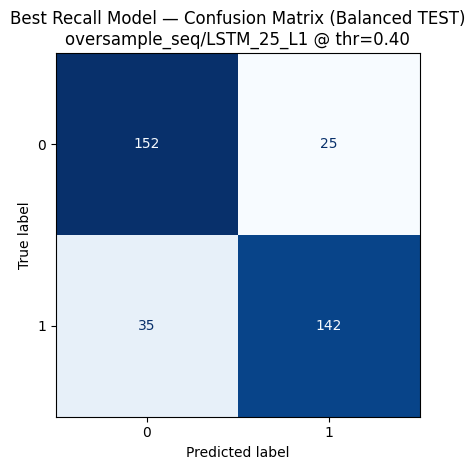

🖼️ Saved balanced confusion matrix: plots/best_confusion_balanced.png
[Best Recall | Balanced TEST] oversample_seq/LSTM_25_L1 @ t=0.40 → TP=142, FP=25, TN=152, FN=35


In [14]:
# ---- 5) Confusion matrix for the best-recall model on a BALANCED TEST ----
def _make_balanced_test(X, y, random_state=42):
    X = np.asarray(X)
    y = np.asarray(y).astype(int).ravel()
    idx0 = np.where(y == 0)[0]
    idx1 = np.where(y == 1)[0]
    if len(idx0) == 0 or len(idx1) == 0:
        raise RuntimeError("Cannot balance: one of the classes is missing in TEST.")
    m = min(len(idx0), len(idx1))
    rs = np.random.RandomState(random_state)
    keep = np.concatenate([
        rs.choice(idx0, m, replace=False),
        rs.choice(idx1, m, replace=False)
    ])
    rs.shuffle(keep)
    return X[keep], y[keep]

# Build balanced test
X_test_bal, y_test_bal = _make_balanced_test(X_test, y_test, random_state=RANDOM_STATE)

# Ensure we have probs for the same best model tag
if best_tag not in probs_map:
    ckpt_path = CKPT_FMT.format(method=best_method, model=best_model)
    if os.path.exists(ckpt_path):
        m = define_models(input_shape)[best_model]
        m.load_weights(ckpt_path)
        probs_map[best_tag] = m.predict(X_test, verbose=0).ravel()
    else:
        raise FileNotFoundError(f"Checkpoint for best model not found: {ckpt_path}")

# Recompute probs on the BALANCED TEST (needed since we subsampled)
m_bal = define_models(input_shape)[best_model]
m_bal.load_weights(CKPT_FMT.format(method=best_method, model=best_model))
p_test_bal = m_bal.predict(X_test_bal, verbose=0).ravel()

# Confusion matrix @ the same threshold used in the paper table
yhat_best_bal = (p_test_bal >= best_thr).astype(int)
cm_bal = confusion_matrix(y_test_bal, yhat_best_bal, labels=[0,1])

plt.figure(figsize=(5.5,5))
disp_bal = ConfusionMatrixDisplay(confusion_matrix=cm_bal, display_labels=[0,1])
disp_bal.plot(values_format='d', cmap='Blues', colorbar=False)
plt.title(f"Best Recall Model — Confusion Matrix (Balanced TEST)\n{best_tag} @ thr={best_thr:.2f}")
plt.tight_layout()
plt.savefig("plots/best_confusion_balanced.png", dpi=300)
plt.show()
print("🖼️ Saved balanced confusion matrix: plots/best_confusion_balanced.png")

tn_b, fp_b, fn_b, tp_b = cm_bal.ravel()
print(f"[Best Recall | Balanced TEST] {best_tag} @ t={best_thr:.2f} → TP={tp_b}, FP={fp_b}, TN={tn_b}, FN={fn_b}")
